## <center><font color="purple">Static Ensemble ML Regressors - Length of Stay Forecasting </font></center>
<center> Firuz Juraev (Sungkyunkwan University) </center>

#### <center><font color='green'> Keywords: LOS, Regression</font></center>

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.ensemble import BaggingRegressor

In [3]:
from sklearn.ensemble import VotingRegressor

In [4]:
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error, 
                             r2_score, 
                             mean_squared_log_error)

In [6]:
# from yellowbrick.regressor import residuals_plot
# from yellowbrick.regressor import prediction_error

In [9]:
from sklearn.feature_selection import mutual_info_classif
# from featurewiz import featurewiz

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [11]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Load Dataset 

In [12]:
dataset = pd.read_csv("Data/neonate_dataset.csv")

In [13]:
dataset.fillna(method="ffill", inplace=True)
y = dataset['LOS']
X = dataset.drop(['LOS'], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=25)

In [15]:
dataset.columns

Index(['GENDER', 'ETHNICITY', 'DATEEVENTS', 'DW10_COUNT', 'D10W_SUM',
       'D10W_MEAN', 'URINE_COUNT', 'URINE_SUM', 'URINE_AVG',
       'MICROBIOLOGY_TEST', 'NEGATIVE_RESULT', 'PRESCRIPTIONS', 'BIRTH_WEIGHT',
       'HEAD_CIRC', 'BANDS', 'MONOs', 'EOSINOPHILS', 'NEUTS', 'LYMPHS',
       'PLATELET', 'LOS', 'bpCuffDiastolic_mean', 'bpCuffDiastolic_max',
       'bpCuffDiastolic_min', 'bpCuffDiastolic_std', 'bpCuffDiastolic_var',
       'bpCuffMean_mean', 'bpCuffMean_max', 'bpCuffMean_min', 'bpCuffMean_std',
       'bpCuffMean_var', 'bpCuffSystolic_mean', 'bpCuffSystolic_max',
       'bpCuffSystolic_min', 'bpCuffSystolic_std', 'bpCuffSystolic_var',
       'glucometer_mean', 'glucometer_max', 'glucometer_min', 'glucometer_std',
       'glucometer_var', 'heartRate_mean', 'heartRate_max', 'heartRate_min',
       'heartRate_std', 'heartRate_var', 'hrAlarmHigh_mean', 'hrAlarmHigh_max',
       'hrAlarmHigh_min', 'hrAlarmHigh_std', 'hrAlarmHigh_var',
       'hrAlarmLow_mean', 'hrAlarmLow_max', 

### Normalization

In [16]:
Min_max_scaler = MinMaxScaler().fit(X_train) 
### StandardScaler()

## Scaling 
X_train_mm_scaled = Min_max_scaler.transform(X_train)
X_test_mm_scaled = Min_max_scaler.transform(X_test)

## Numpy Array to DataFrame 
df_train_mm_scaled = pd.DataFrame(X_train_mm_scaled)
df_test_mm_scaled = pd.DataFrame(X_test_mm_scaled)

In [17]:
# feature selection
def select_features(X_train, y_train, X_test, k=70):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [18]:
X_train_fs, X_test_fs, fs = select_features(df_train_mm_scaled, y_train, df_test_mm_scaled)

### k-fold Cross Validation 

In [19]:
def cv_partitioning(df, k, fraction): 
    dataset_list = [] 
    
    for i in range(0, k): 
        dataset_list.append(df.sample(frac=fraction))
    
    return dataset_list

In [20]:
X_train_fs = X_train[:]
X_test_fs = X_test[:]

train_data = X_train_fs[:]
train_data["LOS"] = y_train 

test_data = X_test_fs[:]
test_data["LOS"] = y_test

train_dfs = cv_partitioning(train_data, 10, 0.98)

### Defining Models 

In [21]:
def get_results(train, test, regressors): 
    
    train_x = train.drop(["LOS"], axis=1) 
    train_y = train["LOS"] 
    
    test_x = test.drop(["LOS"], axis=1) 
    test_y = test["LOS"]
    
    reg_names = [] 
    mse_scores = [] 
    mae_scores = [] 
    r2_scores = [] 
    #mape_scores = [] 
    
    
    for reg in regressors:  
        reg.fit(train_x, train_y)
        y_preds = reg.predict(test_x)
        
        reg_names.append(reg.__class__.__name__)
        mse_scores.append(mean_squared_error(test_y, y_preds, squared=False))
        mae_scores.append(mean_absolute_error(test_y, y_preds))
        r2_scores.append(r2_score(test_y, y_preds))
        #mape_scores.append(mean_absolute_percentage_error(test_y, y_preds))
    
    results = { 'name': reg_names, 
                'rmse': mse_scores, 
                'mae': mae_scores, 
                'r2': r2_scores, 
                #'mape (%)': mape_scores
              }
       
    df = pd.DataFrame.from_dict(results)
    
    return df 
    

In [22]:
regressors = [RandomForestRegressor(), ExtraTreesRegressor(), XGBRegressor(), LGBMRegressor(), 
                GradientBoostingRegressor(), CatBoostRegressor(), AdaBoostRegressor()]

results_data = []
for i in range(0, 10): 
    results_data.append(get_results(train_dfs[i], test_data, regressors))

Learning rate set to 0.042946
0:	learn: 26.5760321	total: 153ms	remaining: 2m 32s
1:	learn: 25.8960566	total: 156ms	remaining: 1m 17s
2:	learn: 25.2979005	total: 159ms	remaining: 52.9s
3:	learn: 24.7084345	total: 163ms	remaining: 40.5s
4:	learn: 24.1523978	total: 166ms	remaining: 33.1s
5:	learn: 23.6338536	total: 171ms	remaining: 28.4s
6:	learn: 23.1801794	total: 175ms	remaining: 24.9s
7:	learn: 22.7564259	total: 179ms	remaining: 22.2s
8:	learn: 22.2678411	total: 183ms	remaining: 20.2s
9:	learn: 21.8343306	total: 187ms	remaining: 18.5s
10:	learn: 21.3935412	total: 191ms	remaining: 17.1s
11:	learn: 20.9733816	total: 195ms	remaining: 16.1s
12:	learn: 20.5957233	total: 198ms	remaining: 15.1s
13:	learn: 20.2497637	total: 202ms	remaining: 14.2s
14:	learn: 19.9042601	total: 205ms	remaining: 13.5s
15:	learn: 19.5607818	total: 209ms	remaining: 12.8s
16:	learn: 19.2661255	total: 212ms	remaining: 12.3s
17:	learn: 18.9741065	total: 216ms	remaining: 11.8s
18:	learn: 18.6933473	total: 219ms	remaini

206:	learn: 9.6621832	total: 864ms	remaining: 3.31s
207:	learn: 9.6308461	total: 867ms	remaining: 3.3s
208:	learn: 9.6156256	total: 871ms	remaining: 3.29s
209:	learn: 9.6035367	total: 874ms	remaining: 3.29s
210:	learn: 9.6014190	total: 878ms	remaining: 3.28s
211:	learn: 9.5989184	total: 881ms	remaining: 3.27s
212:	learn: 9.5831597	total: 885ms	remaining: 3.27s
213:	learn: 9.5819641	total: 888ms	remaining: 3.26s
214:	learn: 9.5670089	total: 892ms	remaining: 3.25s
215:	learn: 9.5536779	total: 895ms	remaining: 3.25s
216:	learn: 9.5369287	total: 898ms	remaining: 3.24s
217:	learn: 9.5235314	total: 901ms	remaining: 3.23s
218:	learn: 9.5123672	total: 904ms	remaining: 3.22s
219:	learn: 9.4945316	total: 908ms	remaining: 3.22s
220:	learn: 9.4928815	total: 911ms	remaining: 3.21s
221:	learn: 9.4912491	total: 915ms	remaining: 3.21s
222:	learn: 9.4791947	total: 918ms	remaining: 3.2s
223:	learn: 9.4772706	total: 922ms	remaining: 3.19s
224:	learn: 9.4637426	total: 926ms	remaining: 3.19s
225:	learn: 9.

387:	learn: 7.4937913	total: 1.56s	remaining: 2.46s
388:	learn: 7.4860637	total: 1.56s	remaining: 2.45s
389:	learn: 7.4790991	total: 1.56s	remaining: 2.45s
390:	learn: 7.4587588	total: 1.57s	remaining: 2.44s
391:	learn: 7.4502997	total: 1.57s	remaining: 2.44s
392:	learn: 7.4461405	total: 1.57s	remaining: 2.43s
393:	learn: 7.4290371	total: 1.58s	remaining: 2.43s
394:	learn: 7.4213108	total: 1.58s	remaining: 2.42s
395:	learn: 7.4052101	total: 1.58s	remaining: 2.42s
396:	learn: 7.4007517	total: 1.59s	remaining: 2.41s
397:	learn: 7.3872855	total: 1.59s	remaining: 2.41s
398:	learn: 7.3765949	total: 1.59s	remaining: 2.4s
399:	learn: 7.3634203	total: 1.6s	remaining: 2.4s
400:	learn: 7.3514190	total: 1.6s	remaining: 2.39s
401:	learn: 7.3388906	total: 1.61s	remaining: 2.39s
402:	learn: 7.3293058	total: 1.61s	remaining: 2.38s
403:	learn: 7.3126763	total: 1.61s	remaining: 2.38s
404:	learn: 7.3076871	total: 1.61s	remaining: 2.37s
405:	learn: 7.3069774	total: 1.62s	remaining: 2.37s
406:	learn: 7.29

587:	learn: 5.7086599	total: 2.26s	remaining: 1.58s
588:	learn: 5.6991219	total: 2.27s	remaining: 1.58s
589:	learn: 5.6910272	total: 2.27s	remaining: 1.58s
590:	learn: 5.6860748	total: 2.28s	remaining: 1.58s
591:	learn: 5.6797893	total: 2.28s	remaining: 1.57s
592:	learn: 5.6737917	total: 2.29s	remaining: 1.57s
593:	learn: 5.6624368	total: 2.29s	remaining: 1.56s
594:	learn: 5.6525543	total: 2.29s	remaining: 1.56s
595:	learn: 5.6449719	total: 2.3s	remaining: 1.56s
596:	learn: 5.6445747	total: 2.3s	remaining: 1.55s
597:	learn: 5.6397944	total: 2.31s	remaining: 1.55s
598:	learn: 5.6331171	total: 2.31s	remaining: 1.55s
599:	learn: 5.6229134	total: 2.31s	remaining: 1.54s
600:	learn: 5.6109178	total: 2.32s	remaining: 1.54s
601:	learn: 5.6049903	total: 2.32s	remaining: 1.53s
602:	learn: 5.5946469	total: 2.32s	remaining: 1.53s
603:	learn: 5.5886881	total: 2.33s	remaining: 1.52s
604:	learn: 5.5854395	total: 2.33s	remaining: 1.52s
605:	learn: 5.5814872	total: 2.33s	remaining: 1.52s
606:	learn: 5.

779:	learn: 4.4818332	total: 2.91s	remaining: 821ms
780:	learn: 4.4745739	total: 2.91s	remaining: 817ms
781:	learn: 4.4721358	total: 2.92s	remaining: 813ms
782:	learn: 4.4675642	total: 2.92s	remaining: 809ms
783:	learn: 4.4610469	total: 2.92s	remaining: 805ms
784:	learn: 4.4556909	total: 2.93s	remaining: 802ms
785:	learn: 4.4552112	total: 2.93s	remaining: 798ms
786:	learn: 4.4511513	total: 2.93s	remaining: 794ms
787:	learn: 4.4444464	total: 2.94s	remaining: 790ms
788:	learn: 4.4375643	total: 2.94s	remaining: 786ms
789:	learn: 4.4301144	total: 2.94s	remaining: 782ms
790:	learn: 4.4211944	total: 2.95s	remaining: 778ms
791:	learn: 4.4137707	total: 2.95s	remaining: 775ms
792:	learn: 4.4075596	total: 2.95s	remaining: 771ms
793:	learn: 4.4012227	total: 2.96s	remaining: 767ms
794:	learn: 4.3943624	total: 2.96s	remaining: 763ms
795:	learn: 4.3862353	total: 2.96s	remaining: 759ms
796:	learn: 4.3820334	total: 2.96s	remaining: 755ms
797:	learn: 4.3760914	total: 2.97s	remaining: 751ms
798:	learn: 

980:	learn: 3.4748359	total: 3.6s	remaining: 69.7ms
981:	learn: 3.4708914	total: 3.6s	remaining: 66ms
982:	learn: 3.4675565	total: 3.61s	remaining: 62.4ms
983:	learn: 3.4636003	total: 3.61s	remaining: 58.7ms
984:	learn: 3.4621954	total: 3.62s	remaining: 55.2ms
985:	learn: 3.4596061	total: 3.63s	remaining: 51.6ms
986:	learn: 3.4560282	total: 3.64s	remaining: 47.9ms
987:	learn: 3.4546740	total: 3.64s	remaining: 44.2ms
988:	learn: 3.4504387	total: 3.65s	remaining: 40.6ms
989:	learn: 3.4446317	total: 3.65s	remaining: 36.9ms
990:	learn: 3.4416593	total: 3.66s	remaining: 33.2ms
991:	learn: 3.4400337	total: 3.66s	remaining: 29.5ms
992:	learn: 3.4345167	total: 3.66s	remaining: 25.8ms
993:	learn: 3.4303340	total: 3.67s	remaining: 22.1ms
994:	learn: 3.4281440	total: 3.67s	remaining: 18.4ms
995:	learn: 3.4228122	total: 3.67s	remaining: 14.8ms
996:	learn: 3.4188472	total: 3.68s	remaining: 11.1ms
997:	learn: 3.4129850	total: 3.68s	remaining: 7.37ms
998:	learn: 3.4095658	total: 3.68s	remaining: 3.69

153:	learn: 10.2902923	total: 523ms	remaining: 2.87s
154:	learn: 10.2854257	total: 526ms	remaining: 2.87s
155:	learn: 10.2699765	total: 530ms	remaining: 2.87s
156:	learn: 10.2547019	total: 534ms	remaining: 2.87s
157:	learn: 10.2490266	total: 537ms	remaining: 2.86s
158:	learn: 10.2158463	total: 540ms	remaining: 2.86s
159:	learn: 10.2094414	total: 544ms	remaining: 2.86s
160:	learn: 10.1832516	total: 548ms	remaining: 2.85s
161:	learn: 10.1663662	total: 551ms	remaining: 2.85s
162:	learn: 10.1517665	total: 554ms	remaining: 2.84s
163:	learn: 10.1335372	total: 557ms	remaining: 2.84s
164:	learn: 10.1163893	total: 560ms	remaining: 2.83s
165:	learn: 10.1037786	total: 563ms	remaining: 2.83s
166:	learn: 10.0912249	total: 566ms	remaining: 2.83s
167:	learn: 10.0886374	total: 570ms	remaining: 2.82s
168:	learn: 10.0754991	total: 573ms	remaining: 2.82s
169:	learn: 10.0688597	total: 576ms	remaining: 2.81s
170:	learn: 10.0647809	total: 579ms	remaining: 2.81s
171:	learn: 10.0412356	total: 582ms	remaining:

344:	learn: 7.8951243	total: 1.22s	remaining: 2.31s
345:	learn: 7.8806191	total: 1.23s	remaining: 2.32s
346:	learn: 7.8794500	total: 1.23s	remaining: 2.31s
347:	learn: 7.8697127	total: 1.24s	remaining: 2.31s
348:	learn: 7.8600064	total: 1.24s	remaining: 2.32s
349:	learn: 7.8446451	total: 1.25s	remaining: 2.31s
350:	learn: 7.8369031	total: 1.25s	remaining: 2.31s
351:	learn: 7.8189657	total: 1.25s	remaining: 2.31s
352:	learn: 7.8085401	total: 1.26s	remaining: 2.3s
353:	learn: 7.7944853	total: 1.26s	remaining: 2.3s
354:	learn: 7.7931978	total: 1.26s	remaining: 2.29s
355:	learn: 7.7866985	total: 1.27s	remaining: 2.29s
356:	learn: 7.7826230	total: 1.27s	remaining: 2.29s
357:	learn: 7.7633942	total: 1.27s	remaining: 2.28s
358:	learn: 7.7510583	total: 1.27s	remaining: 2.28s
359:	learn: 7.7407732	total: 1.28s	remaining: 2.27s
360:	learn: 7.7400137	total: 1.28s	remaining: 2.27s
361:	learn: 7.7361146	total: 1.28s	remaining: 2.26s
362:	learn: 7.7226506	total: 1.29s	remaining: 2.26s
363:	learn: 7.

540:	learn: 6.0132808	total: 1.9s	remaining: 1.61s
541:	learn: 6.0082384	total: 1.91s	remaining: 1.61s
542:	learn: 5.9984779	total: 1.91s	remaining: 1.61s
543:	learn: 5.9907427	total: 1.91s	remaining: 1.6s
544:	learn: 5.9884077	total: 1.92s	remaining: 1.6s
545:	learn: 5.9792034	total: 1.92s	remaining: 1.6s
546:	learn: 5.9663754	total: 1.92s	remaining: 1.59s
547:	learn: 5.9510072	total: 1.93s	remaining: 1.59s
548:	learn: 5.9371799	total: 1.93s	remaining: 1.59s
549:	learn: 5.9235430	total: 1.93s	remaining: 1.58s
550:	learn: 5.9147937	total: 1.94s	remaining: 1.58s
551:	learn: 5.9082936	total: 1.94s	remaining: 1.57s
552:	learn: 5.9005242	total: 1.94s	remaining: 1.57s
553:	learn: 5.8937359	total: 1.95s	remaining: 1.57s
554:	learn: 5.8875540	total: 1.95s	remaining: 1.56s
555:	learn: 5.8822135	total: 1.95s	remaining: 1.56s
556:	learn: 5.8739590	total: 1.96s	remaining: 1.56s
557:	learn: 5.8675123	total: 1.96s	remaining: 1.55s
558:	learn: 5.8645736	total: 1.96s	remaining: 1.55s
559:	learn: 5.85

729:	learn: 4.6400713	total: 2.56s	remaining: 949ms
730:	learn: 4.6344811	total: 2.57s	remaining: 946ms
731:	learn: 4.6287828	total: 2.57s	remaining: 942ms
732:	learn: 4.6223187	total: 2.58s	remaining: 939ms
733:	learn: 4.6169354	total: 2.58s	remaining: 935ms
734:	learn: 4.6088444	total: 2.58s	remaining: 932ms
735:	learn: 4.6017249	total: 2.59s	remaining: 928ms
736:	learn: 4.5956321	total: 2.59s	remaining: 924ms
737:	learn: 4.5905886	total: 2.59s	remaining: 921ms
738:	learn: 4.5868881	total: 2.6s	remaining: 917ms
739:	learn: 4.5807954	total: 2.6s	remaining: 914ms
740:	learn: 4.5693350	total: 2.6s	remaining: 910ms
741:	learn: 4.5609967	total: 2.61s	remaining: 907ms
742:	learn: 4.5570605	total: 2.61s	remaining: 903ms
743:	learn: 4.5538637	total: 2.61s	remaining: 899ms
744:	learn: 4.5455678	total: 2.62s	remaining: 896ms
745:	learn: 4.5372740	total: 2.62s	remaining: 892ms
746:	learn: 4.5346154	total: 2.62s	remaining: 889ms
747:	learn: 4.5269964	total: 2.63s	remaining: 885ms
748:	learn: 4.5

926:	learn: 3.6237796	total: 3.25s	remaining: 256ms
927:	learn: 3.6176262	total: 3.26s	remaining: 253ms
928:	learn: 3.6113501	total: 3.27s	remaining: 250ms
929:	learn: 3.6047033	total: 3.27s	remaining: 246ms
930:	learn: 3.5983162	total: 3.27s	remaining: 242ms
931:	learn: 3.5940880	total: 3.27s	remaining: 239ms
932:	learn: 3.5890921	total: 3.28s	remaining: 236ms
933:	learn: 3.5878946	total: 3.28s	remaining: 232ms
934:	learn: 3.5848796	total: 3.29s	remaining: 228ms
935:	learn: 3.5808047	total: 3.29s	remaining: 225ms
936:	learn: 3.5760678	total: 3.29s	remaining: 221ms
937:	learn: 3.5720131	total: 3.3s	remaining: 218ms
938:	learn: 3.5641862	total: 3.3s	remaining: 214ms
939:	learn: 3.5591151	total: 3.3s	remaining: 211ms
940:	learn: 3.5538236	total: 3.31s	remaining: 207ms
941:	learn: 3.5513773	total: 3.31s	remaining: 204ms
942:	learn: 3.5438360	total: 3.31s	remaining: 200ms
943:	learn: 3.5408374	total: 3.32s	remaining: 197ms
944:	learn: 3.5351953	total: 3.32s	remaining: 193ms
945:	learn: 3.5

97:	learn: 11.4423623	total: 343ms	remaining: 3.16s
98:	learn: 11.4247960	total: 347ms	remaining: 3.15s
99:	learn: 11.3946547	total: 350ms	remaining: 3.15s
100:	learn: 11.3822976	total: 353ms	remaining: 3.14s
101:	learn: 11.3572218	total: 356ms	remaining: 3.13s
102:	learn: 11.3096987	total: 359ms	remaining: 3.13s
103:	learn: 11.2867099	total: 364ms	remaining: 3.14s
104:	learn: 11.2613487	total: 370ms	remaining: 3.15s
105:	learn: 11.2331594	total: 376ms	remaining: 3.17s
106:	learn: 11.2090572	total: 379ms	remaining: 3.16s
107:	learn: 11.1916829	total: 382ms	remaining: 3.16s
108:	learn: 11.1830706	total: 385ms	remaining: 3.15s
109:	learn: 11.1672017	total: 389ms	remaining: 3.14s
110:	learn: 11.1356699	total: 392ms	remaining: 3.14s
111:	learn: 11.1111068	total: 395ms	remaining: 3.13s
112:	learn: 11.0931731	total: 398ms	remaining: 3.12s
113:	learn: 11.0718501	total: 401ms	remaining: 3.12s
114:	learn: 11.0437075	total: 404ms	remaining: 3.11s
115:	learn: 11.0405478	total: 407ms	remaining: 3.

254:	learn: 9.2115811	total: 859ms	remaining: 2.51s
255:	learn: 9.1937179	total: 862ms	remaining: 2.51s
256:	learn: 9.1782311	total: 865ms	remaining: 2.5s
257:	learn: 9.1624077	total: 869ms	remaining: 2.5s
258:	learn: 9.1613203	total: 872ms	remaining: 2.49s
259:	learn: 9.1442435	total: 875ms	remaining: 2.49s
260:	learn: 9.1205570	total: 878ms	remaining: 2.49s
261:	learn: 9.1186848	total: 881ms	remaining: 2.48s
262:	learn: 9.1097467	total: 884ms	remaining: 2.48s
263:	learn: 9.0893371	total: 887ms	remaining: 2.47s
264:	learn: 9.0686568	total: 891ms	remaining: 2.47s
265:	learn: 9.0440421	total: 894ms	remaining: 2.47s
266:	learn: 9.0276500	total: 897ms	remaining: 2.46s
267:	learn: 9.0240013	total: 900ms	remaining: 2.46s
268:	learn: 9.0110198	total: 903ms	remaining: 2.45s
269:	learn: 8.9962335	total: 907ms	remaining: 2.45s
270:	learn: 8.9930375	total: 910ms	remaining: 2.45s
271:	learn: 8.9690788	total: 913ms	remaining: 2.44s
272:	learn: 8.9542719	total: 917ms	remaining: 2.44s
273:	learn: 8.

434:	learn: 7.1539209	total: 1.55s	remaining: 2.01s
435:	learn: 7.1360275	total: 1.55s	remaining: 2.01s
436:	learn: 7.1218030	total: 1.55s	remaining: 2s
437:	learn: 7.1109926	total: 1.56s	remaining: 2s
438:	learn: 7.0921579	total: 1.56s	remaining: 2s
439:	learn: 7.0850423	total: 1.56s	remaining: 1.99s
440:	learn: 7.0725262	total: 1.57s	remaining: 1.99s
441:	learn: 7.0665003	total: 1.57s	remaining: 1.98s
442:	learn: 7.0514845	total: 1.57s	remaining: 1.98s
443:	learn: 7.0386746	total: 1.58s	remaining: 1.98s
444:	learn: 7.0184434	total: 1.58s	remaining: 1.97s
445:	learn: 7.0079012	total: 1.58s	remaining: 1.97s
446:	learn: 6.9936890	total: 1.59s	remaining: 1.97s
447:	learn: 6.9826946	total: 1.59s	remaining: 1.96s
448:	learn: 6.9745366	total: 1.59s	remaining: 1.96s
449:	learn: 6.9640629	total: 1.61s	remaining: 1.97s
450:	learn: 6.9424806	total: 1.62s	remaining: 1.97s
451:	learn: 6.9306956	total: 1.62s	remaining: 1.97s
452:	learn: 6.9179108	total: 1.63s	remaining: 1.97s
453:	learn: 6.8959590

627:	learn: 5.4400977	total: 2.24s	remaining: 1.33s
628:	learn: 5.4312813	total: 2.24s	remaining: 1.32s
629:	learn: 5.4272442	total: 2.25s	remaining: 1.32s
630:	learn: 5.4247663	total: 2.25s	remaining: 1.31s
631:	learn: 5.4243431	total: 2.25s	remaining: 1.31s
632:	learn: 5.4141627	total: 2.25s	remaining: 1.31s
633:	learn: 5.4030428	total: 2.26s	remaining: 1.3s
634:	learn: 5.4024434	total: 2.26s	remaining: 1.3s
635:	learn: 5.4019619	total: 2.26s	remaining: 1.3s
636:	learn: 5.3930459	total: 2.27s	remaining: 1.29s
637:	learn: 5.3867321	total: 2.27s	remaining: 1.29s
638:	learn: 5.3797706	total: 2.27s	remaining: 1.28s
639:	learn: 5.3703408	total: 2.28s	remaining: 1.28s
640:	learn: 5.3567429	total: 2.28s	remaining: 1.28s
641:	learn: 5.3498042	total: 2.28s	remaining: 1.27s
642:	learn: 5.3463859	total: 2.29s	remaining: 1.27s
643:	learn: 5.3433905	total: 2.29s	remaining: 1.27s
644:	learn: 5.3358630	total: 2.29s	remaining: 1.26s
645:	learn: 5.3292750	total: 2.3s	remaining: 1.26s
646:	learn: 5.32

810:	learn: 4.2585034	total: 2.93s	remaining: 683ms
811:	learn: 4.2551522	total: 2.93s	remaining: 679ms
812:	learn: 4.2477918	total: 2.94s	remaining: 676ms
813:	learn: 4.2416417	total: 2.94s	remaining: 672ms
814:	learn: 4.2349241	total: 2.94s	remaining: 668ms
815:	learn: 4.2270235	total: 2.95s	remaining: 665ms
816:	learn: 4.2243141	total: 2.95s	remaining: 661ms
817:	learn: 4.2204103	total: 2.96s	remaining: 658ms
818:	learn: 4.2158489	total: 2.96s	remaining: 654ms
819:	learn: 4.2113064	total: 2.96s	remaining: 651ms
820:	learn: 4.2073808	total: 2.97s	remaining: 647ms
821:	learn: 4.2025584	total: 2.97s	remaining: 643ms
822:	learn: 4.1977650	total: 2.98s	remaining: 640ms
823:	learn: 4.1946863	total: 2.98s	remaining: 636ms
824:	learn: 4.1879576	total: 2.98s	remaining: 633ms
825:	learn: 4.1786886	total: 2.99s	remaining: 629ms
826:	learn: 4.1716044	total: 2.99s	remaining: 626ms
827:	learn: 4.1680029	total: 3s	remaining: 622ms
828:	learn: 4.1658804	total: 3s	remaining: 619ms
829:	learn: 4.1601

979:	learn: 3.4447172	total: 3.62s	remaining: 73.9ms
980:	learn: 3.4408267	total: 3.62s	remaining: 70.2ms
981:	learn: 3.4348652	total: 3.63s	remaining: 66.5ms
982:	learn: 3.4311395	total: 3.63s	remaining: 62.8ms
983:	learn: 3.4287005	total: 3.63s	remaining: 59.1ms
984:	learn: 3.4232212	total: 3.64s	remaining: 55.4ms
985:	learn: 3.4179422	total: 3.64s	remaining: 51.7ms
986:	learn: 3.4159408	total: 3.64s	remaining: 48ms
987:	learn: 3.4107356	total: 3.65s	remaining: 44.3ms
988:	learn: 3.4102990	total: 3.65s	remaining: 40.6ms
989:	learn: 3.4075551	total: 3.65s	remaining: 36.9ms
990:	learn: 3.4045693	total: 3.66s	remaining: 33.2ms
991:	learn: 3.4014753	total: 3.66s	remaining: 29.5ms
992:	learn: 3.3948563	total: 3.66s	remaining: 25.8ms
993:	learn: 3.3919253	total: 3.67s	remaining: 22.1ms
994:	learn: 3.3871543	total: 3.67s	remaining: 18.4ms
995:	learn: 3.3847523	total: 3.67s	remaining: 14.8ms
996:	learn: 3.3821348	total: 3.67s	remaining: 11.1ms
997:	learn: 3.3783733	total: 3.68s	remaining: 7.

140:	learn: 10.4304630	total: 525ms	remaining: 3.2s
141:	learn: 10.4125585	total: 528ms	remaining: 3.19s
142:	learn: 10.3822716	total: 532ms	remaining: 3.19s
143:	learn: 10.3552471	total: 535ms	remaining: 3.18s
144:	learn: 10.3402951	total: 539ms	remaining: 3.17s
145:	learn: 10.3210301	total: 542ms	remaining: 3.17s
146:	learn: 10.3050621	total: 545ms	remaining: 3.16s
147:	learn: 10.3005002	total: 549ms	remaining: 3.16s
148:	learn: 10.2986755	total: 553ms	remaining: 3.16s
149:	learn: 10.2797315	total: 557ms	remaining: 3.15s
150:	learn: 10.2468077	total: 561ms	remaining: 3.15s
151:	learn: 10.2378351	total: 573ms	remaining: 3.19s
152:	learn: 10.2224792	total: 580ms	remaining: 3.21s
153:	learn: 10.2151982	total: 585ms	remaining: 3.21s
154:	learn: 10.2078917	total: 589ms	remaining: 3.21s
155:	learn: 10.2010825	total: 594ms	remaining: 3.21s
156:	learn: 10.1921147	total: 599ms	remaining: 3.22s
157:	learn: 10.1831903	total: 602ms	remaining: 3.21s
158:	learn: 10.1733089	total: 606ms	remaining: 

317:	learn: 8.3166308	total: 1.22s	remaining: 2.61s
318:	learn: 8.3025912	total: 1.22s	remaining: 2.61s
319:	learn: 8.2871197	total: 1.23s	remaining: 2.61s
320:	learn: 8.2705942	total: 1.24s	remaining: 2.62s
321:	learn: 8.2591235	total: 1.24s	remaining: 2.62s
322:	learn: 8.2478736	total: 1.26s	remaining: 2.64s
323:	learn: 8.2317232	total: 1.27s	remaining: 2.65s
324:	learn: 8.2198004	total: 1.28s	remaining: 2.65s
325:	learn: 8.2136153	total: 1.29s	remaining: 2.66s
326:	learn: 8.2024271	total: 1.29s	remaining: 2.66s
327:	learn: 8.1879529	total: 1.3s	remaining: 2.66s
328:	learn: 8.1761172	total: 1.3s	remaining: 2.66s
329:	learn: 8.1648707	total: 1.31s	remaining: 2.67s
330:	learn: 8.1496114	total: 1.32s	remaining: 2.66s
331:	learn: 8.1441472	total: 1.32s	remaining: 2.66s
332:	learn: 8.1337520	total: 1.32s	remaining: 2.65s
333:	learn: 8.1157985	total: 1.33s	remaining: 2.65s
334:	learn: 8.1069467	total: 1.33s	remaining: 2.64s
335:	learn: 8.1059538	total: 1.33s	remaining: 2.64s
336:	learn: 8.

488:	learn: 6.5626835	total: 1.91s	remaining: 2s
489:	learn: 6.5567571	total: 1.92s	remaining: 1.99s
490:	learn: 6.5480688	total: 1.92s	remaining: 1.99s
491:	learn: 6.5444238	total: 1.93s	remaining: 1.99s
492:	learn: 6.5377039	total: 1.93s	remaining: 1.99s
493:	learn: 6.5261298	total: 1.94s	remaining: 1.98s
494:	learn: 6.5190200	total: 1.94s	remaining: 1.98s
495:	learn: 6.5159423	total: 1.94s	remaining: 1.97s
496:	learn: 6.5111509	total: 1.95s	remaining: 1.97s
497:	learn: 6.5035554	total: 1.95s	remaining: 1.97s
498:	learn: 6.4990706	total: 1.95s	remaining: 1.96s
499:	learn: 6.4938896	total: 1.96s	remaining: 1.96s
500:	learn: 6.4882069	total: 1.96s	remaining: 1.95s
501:	learn: 6.4876956	total: 1.96s	remaining: 1.95s
502:	learn: 6.4784813	total: 1.97s	remaining: 1.94s
503:	learn: 6.4632709	total: 1.97s	remaining: 1.94s
504:	learn: 6.4533690	total: 1.97s	remaining: 1.94s
505:	learn: 6.4469314	total: 1.98s	remaining: 1.93s
506:	learn: 6.4328278	total: 1.98s	remaining: 1.93s
507:	learn: 6.4

680:	learn: 5.0507316	total: 2.77s	remaining: 1.3s
681:	learn: 5.0490829	total: 2.77s	remaining: 1.29s
682:	learn: 5.0429402	total: 2.77s	remaining: 1.29s
683:	learn: 5.0322436	total: 2.78s	remaining: 1.28s
684:	learn: 5.0240916	total: 2.78s	remaining: 1.28s
685:	learn: 5.0162594	total: 2.79s	remaining: 1.28s
686:	learn: 5.0053213	total: 2.79s	remaining: 1.27s
687:	learn: 5.0016356	total: 2.79s	remaining: 1.27s
688:	learn: 4.9950759	total: 2.8s	remaining: 1.26s
689:	learn: 4.9919063	total: 2.8s	remaining: 1.26s
690:	learn: 4.9822008	total: 2.81s	remaining: 1.25s
691:	learn: 4.9731300	total: 2.81s	remaining: 1.25s
692:	learn: 4.9655159	total: 2.82s	remaining: 1.25s
693:	learn: 4.9651138	total: 2.82s	remaining: 1.24s
694:	learn: 4.9564583	total: 2.83s	remaining: 1.24s
695:	learn: 4.9529015	total: 2.83s	remaining: 1.24s
696:	learn: 4.9452790	total: 2.84s	remaining: 1.23s
697:	learn: 4.9366577	total: 2.84s	remaining: 1.23s
698:	learn: 4.9294166	total: 2.84s	remaining: 1.22s
699:	learn: 4.9

879:	learn: 3.9176260	total: 3.46s	remaining: 471ms
880:	learn: 3.9147749	total: 3.46s	remaining: 467ms
881:	learn: 3.9097248	total: 3.46s	remaining: 463ms
882:	learn: 3.9028656	total: 3.47s	remaining: 459ms
883:	learn: 3.8961668	total: 3.47s	remaining: 455ms
884:	learn: 3.8952366	total: 3.47s	remaining: 451ms
885:	learn: 3.8876088	total: 3.48s	remaining: 447ms
886:	learn: 3.8820173	total: 3.48s	remaining: 443ms
887:	learn: 3.8768393	total: 3.48s	remaining: 439ms
888:	learn: 3.8712150	total: 3.49s	remaining: 435ms
889:	learn: 3.8659251	total: 3.49s	remaining: 431ms
890:	learn: 3.8627101	total: 3.49s	remaining: 427ms
891:	learn: 3.8601521	total: 3.5s	remaining: 423ms
892:	learn: 3.8524407	total: 3.5s	remaining: 419ms
893:	learn: 3.8442708	total: 3.5s	remaining: 415ms
894:	learn: 3.8398725	total: 3.5s	remaining: 411ms
895:	learn: 3.8351684	total: 3.51s	remaining: 408ms
896:	learn: 3.8284714	total: 3.52s	remaining: 404ms
897:	learn: 3.8242230	total: 3.52s	remaining: 400ms
898:	learn: 3.81

46:	learn: 13.8130654	total: 163ms	remaining: 3.31s
47:	learn: 13.7277238	total: 167ms	remaining: 3.31s
48:	learn: 13.6578001	total: 170ms	remaining: 3.3s
49:	learn: 13.5577536	total: 173ms	remaining: 3.29s
50:	learn: 13.4776054	total: 176ms	remaining: 3.28s
51:	learn: 13.3984796	total: 180ms	remaining: 3.27s
52:	learn: 13.3183969	total: 183ms	remaining: 3.27s
53:	learn: 13.2393666	total: 186ms	remaining: 3.26s
54:	learn: 13.1537757	total: 189ms	remaining: 3.25s
55:	learn: 13.0886180	total: 193ms	remaining: 3.25s
56:	learn: 13.0335959	total: 196ms	remaining: 3.24s
57:	learn: 12.9560055	total: 199ms	remaining: 3.23s
58:	learn: 12.9001970	total: 202ms	remaining: 3.23s
59:	learn: 12.8260379	total: 205ms	remaining: 3.22s
60:	learn: 12.7531412	total: 209ms	remaining: 3.21s
61:	learn: 12.6908855	total: 212ms	remaining: 3.2s
62:	learn: 12.6395396	total: 215ms	remaining: 3.2s
63:	learn: 12.5876339	total: 218ms	remaining: 3.19s
64:	learn: 12.5314655	total: 221ms	remaining: 3.18s
65:	learn: 12.4

247:	learn: 9.1124748	total: 853ms	remaining: 2.59s
248:	learn: 9.1017751	total: 857ms	remaining: 2.58s
249:	learn: 9.0837860	total: 860ms	remaining: 2.58s
250:	learn: 9.0684590	total: 863ms	remaining: 2.58s
251:	learn: 9.0477509	total: 867ms	remaining: 2.57s
252:	learn: 9.0365761	total: 870ms	remaining: 2.57s
253:	learn: 9.0245660	total: 873ms	remaining: 2.56s
254:	learn: 9.0149621	total: 876ms	remaining: 2.56s
255:	learn: 9.0015014	total: 879ms	remaining: 2.56s
256:	learn: 8.9931222	total: 882ms	remaining: 2.55s
257:	learn: 8.9708626	total: 886ms	remaining: 2.55s
258:	learn: 8.9588628	total: 889ms	remaining: 2.54s
259:	learn: 8.9443531	total: 892ms	remaining: 2.54s
260:	learn: 8.9380033	total: 895ms	remaining: 2.53s
261:	learn: 8.9294395	total: 898ms	remaining: 2.53s
262:	learn: 8.9059390	total: 902ms	remaining: 2.53s
263:	learn: 8.9017828	total: 905ms	remaining: 2.52s
264:	learn: 8.8932663	total: 908ms	remaining: 2.52s
265:	learn: 8.8845219	total: 912ms	remaining: 2.52s
266:	learn: 

427:	learn: 6.9333570	total: 1.54s	remaining: 2.07s
428:	learn: 6.9248044	total: 1.55s	remaining: 2.06s
429:	learn: 6.9102581	total: 1.55s	remaining: 2.06s
430:	learn: 6.8966566	total: 1.56s	remaining: 2.05s
431:	learn: 6.8873202	total: 1.56s	remaining: 2.05s
432:	learn: 6.8864217	total: 1.56s	remaining: 2.05s
433:	learn: 6.8858429	total: 1.56s	remaining: 2.04s
434:	learn: 6.8736820	total: 1.57s	remaining: 2.04s
435:	learn: 6.8621646	total: 1.57s	remaining: 2.03s
436:	learn: 6.8469545	total: 1.57s	remaining: 2.03s
437:	learn: 6.8306091	total: 1.58s	remaining: 2.02s
438:	learn: 6.8173169	total: 1.58s	remaining: 2.02s
439:	learn: 6.8055553	total: 1.58s	remaining: 2.02s
440:	learn: 6.7944698	total: 1.59s	remaining: 2.01s
441:	learn: 6.7828696	total: 1.59s	remaining: 2.01s
442:	learn: 6.7808289	total: 1.59s	remaining: 2s
443:	learn: 6.7740901	total: 1.6s	remaining: 2s
444:	learn: 6.7608145	total: 1.6s	remaining: 2s
445:	learn: 6.7522216	total: 1.6s	remaining: 1.99s
446:	learn: 6.7424506	to

634:	learn: 5.1970306	total: 2.23s	remaining: 1.28s
635:	learn: 5.1929836	total: 2.24s	remaining: 1.28s
636:	learn: 5.1844749	total: 2.24s	remaining: 1.28s
637:	learn: 5.1788310	total: 2.24s	remaining: 1.27s
638:	learn: 5.1701717	total: 2.25s	remaining: 1.27s
639:	learn: 5.1675375	total: 2.25s	remaining: 1.26s
640:	learn: 5.1586952	total: 2.25s	remaining: 1.26s
641:	learn: 5.1514348	total: 2.25s	remaining: 1.26s
642:	learn: 5.1466996	total: 2.26s	remaining: 1.25s
643:	learn: 5.1363874	total: 2.26s	remaining: 1.25s
644:	learn: 5.1280786	total: 2.27s	remaining: 1.25s
645:	learn: 5.1139509	total: 2.27s	remaining: 1.24s
646:	learn: 5.1051846	total: 2.27s	remaining: 1.24s
647:	learn: 5.0973881	total: 2.28s	remaining: 1.24s
648:	learn: 5.0869978	total: 2.29s	remaining: 1.24s
649:	learn: 5.0807562	total: 2.31s	remaining: 1.24s
650:	learn: 5.0709383	total: 2.31s	remaining: 1.24s
651:	learn: 5.0645696	total: 2.31s	remaining: 1.24s
652:	learn: 5.0580257	total: 2.32s	remaining: 1.23s
653:	learn: 

819:	learn: 4.0479142	total: 2.93s	remaining: 643ms
820:	learn: 4.0437717	total: 2.93s	remaining: 639ms
821:	learn: 4.0384812	total: 2.93s	remaining: 635ms
822:	learn: 4.0336388	total: 2.94s	remaining: 632ms
823:	learn: 4.0292073	total: 2.94s	remaining: 628ms
824:	learn: 4.0255992	total: 2.94s	remaining: 624ms
825:	learn: 4.0209917	total: 2.95s	remaining: 621ms
826:	learn: 4.0201151	total: 2.95s	remaining: 617ms
827:	learn: 4.0136176	total: 2.95s	remaining: 613ms
828:	learn: 4.0082733	total: 2.96s	remaining: 610ms
829:	learn: 4.0021978	total: 2.96s	remaining: 606ms
830:	learn: 3.9934317	total: 2.96s	remaining: 602ms
831:	learn: 3.9854187	total: 2.96s	remaining: 599ms
832:	learn: 3.9800693	total: 2.97s	remaining: 595ms
833:	learn: 3.9714434	total: 2.97s	remaining: 591ms
834:	learn: 3.9663633	total: 2.97s	remaining: 588ms
835:	learn: 3.9615883	total: 2.98s	remaining: 584ms
836:	learn: 3.9564980	total: 2.98s	remaining: 581ms
837:	learn: 3.9497194	total: 2.98s	remaining: 577ms
838:	learn: 

978:	learn: 3.3031746	total: 3.44s	remaining: 73.9ms
979:	learn: 3.2968848	total: 3.45s	remaining: 70.4ms
980:	learn: 3.2906172	total: 3.45s	remaining: 66.8ms
981:	learn: 3.2875088	total: 3.45s	remaining: 63.3ms
982:	learn: 3.2857000	total: 3.46s	remaining: 59.8ms
983:	learn: 3.2801587	total: 3.46s	remaining: 56.3ms
984:	learn: 3.2775404	total: 3.46s	remaining: 52.8ms
985:	learn: 3.2762726	total: 3.47s	remaining: 49.2ms
986:	learn: 3.2700191	total: 3.47s	remaining: 45.7ms
987:	learn: 3.2675920	total: 3.47s	remaining: 42.2ms
988:	learn: 3.2643732	total: 3.48s	remaining: 38.7ms
989:	learn: 3.2622294	total: 3.48s	remaining: 35.2ms
990:	learn: 3.2581446	total: 3.48s	remaining: 31.6ms
991:	learn: 3.2563354	total: 3.49s	remaining: 28.1ms
992:	learn: 3.2498142	total: 3.49s	remaining: 24.6ms
993:	learn: 3.2473408	total: 3.5s	remaining: 21.1ms
994:	learn: 3.2439595	total: 3.5s	remaining: 17.6ms
995:	learn: 3.2414548	total: 3.51s	remaining: 14.1ms
996:	learn: 3.2393246	total: 3.51s	remaining: 10

148:	learn: 10.3559464	total: 516ms	remaining: 2.94s
149:	learn: 10.3186902	total: 519ms	remaining: 2.94s
150:	learn: 10.2992649	total: 522ms	remaining: 2.93s
151:	learn: 10.2748472	total: 525ms	remaining: 2.93s
152:	learn: 10.2731814	total: 528ms	remaining: 2.92s
153:	learn: 10.2695365	total: 531ms	remaining: 2.92s
154:	learn: 10.2624472	total: 535ms	remaining: 2.91s
155:	learn: 10.2441678	total: 538ms	remaining: 2.91s
156:	learn: 10.2133894	total: 541ms	remaining: 2.9s
157:	learn: 10.2094187	total: 544ms	remaining: 2.9s
158:	learn: 10.2001624	total: 547ms	remaining: 2.89s
159:	learn: 10.1946714	total: 550ms	remaining: 2.89s
160:	learn: 10.1733878	total: 553ms	remaining: 2.88s
161:	learn: 10.1581021	total: 556ms	remaining: 2.88s
162:	learn: 10.1386943	total: 560ms	remaining: 2.87s
163:	learn: 10.1219222	total: 563ms	remaining: 2.87s
164:	learn: 10.1155220	total: 566ms	remaining: 2.86s
165:	learn: 10.0951787	total: 569ms	remaining: 2.86s
166:	learn: 10.0750146	total: 573ms	remaining: 2

343:	learn: 7.9032469	total: 1.21s	remaining: 2.3s
344:	learn: 7.8965551	total: 1.21s	remaining: 2.3s
345:	learn: 7.8884145	total: 1.22s	remaining: 2.3s
346:	learn: 7.8799391	total: 1.22s	remaining: 2.3s
347:	learn: 7.8636456	total: 1.23s	remaining: 2.3s
348:	learn: 7.8548741	total: 1.23s	remaining: 2.3s
349:	learn: 7.8387187	total: 1.24s	remaining: 2.3s
350:	learn: 7.8308112	total: 1.24s	remaining: 2.3s
351:	learn: 7.8208536	total: 1.25s	remaining: 2.3s
352:	learn: 7.8057378	total: 1.25s	remaining: 2.3s
353:	learn: 7.7920340	total: 1.26s	remaining: 2.3s
354:	learn: 7.7756768	total: 1.26s	remaining: 2.3s
355:	learn: 7.7613176	total: 1.27s	remaining: 2.29s
356:	learn: 7.7440354	total: 1.27s	remaining: 2.29s
357:	learn: 7.7233019	total: 1.27s	remaining: 2.29s
358:	learn: 7.7069131	total: 1.28s	remaining: 2.28s
359:	learn: 7.6964256	total: 1.28s	remaining: 2.28s
360:	learn: 7.6750937	total: 1.28s	remaining: 2.27s
361:	learn: 7.6684900	total: 1.29s	remaining: 2.27s
362:	learn: 7.6579166	to

535:	learn: 6.0159367	total: 1.9s	remaining: 1.64s
536:	learn: 6.0065728	total: 1.9s	remaining: 1.64s
537:	learn: 5.9922330	total: 1.9s	remaining: 1.63s
538:	learn: 5.9842517	total: 1.9s	remaining: 1.63s
539:	learn: 5.9802062	total: 1.91s	remaining: 1.63s
540:	learn: 5.9695037	total: 1.91s	remaining: 1.62s
541:	learn: 5.9643224	total: 1.91s	remaining: 1.62s
542:	learn: 5.9587976	total: 1.92s	remaining: 1.61s
543:	learn: 5.9472321	total: 1.92s	remaining: 1.61s
544:	learn: 5.9404829	total: 1.92s	remaining: 1.61s
545:	learn: 5.9305606	total: 1.93s	remaining: 1.6s
546:	learn: 5.9301700	total: 1.93s	remaining: 1.6s
547:	learn: 5.9142516	total: 1.93s	remaining: 1.59s
548:	learn: 5.9113660	total: 1.94s	remaining: 1.59s
549:	learn: 5.9046403	total: 1.94s	remaining: 1.59s
550:	learn: 5.8976966	total: 1.94s	remaining: 1.58s
551:	learn: 5.8900054	total: 1.95s	remaining: 1.58s
552:	learn: 5.8863135	total: 1.95s	remaining: 1.57s
553:	learn: 5.8761368	total: 1.95s	remaining: 1.57s
554:	learn: 5.8689

730:	learn: 4.5852209	total: 2.58s	remaining: 951ms
731:	learn: 4.5776863	total: 2.59s	remaining: 947ms
732:	learn: 4.5687873	total: 2.59s	remaining: 944ms
733:	learn: 4.5638563	total: 2.6s	remaining: 941ms
734:	learn: 4.5634360	total: 2.6s	remaining: 937ms
735:	learn: 4.5580168	total: 2.6s	remaining: 934ms
736:	learn: 4.5539235	total: 2.61s	remaining: 930ms
737:	learn: 4.5470420	total: 2.61s	remaining: 927ms
738:	learn: 4.5397456	total: 2.61s	remaining: 923ms
739:	learn: 4.5331105	total: 2.62s	remaining: 919ms
740:	learn: 4.5259263	total: 2.62s	remaining: 916ms
741:	learn: 4.5213873	total: 2.62s	remaining: 912ms
742:	learn: 4.5149202	total: 2.63s	remaining: 909ms
743:	learn: 4.5094511	total: 2.63s	remaining: 905ms
744:	learn: 4.5048275	total: 2.63s	remaining: 901ms
745:	learn: 4.4999798	total: 2.64s	remaining: 898ms
746:	learn: 4.4929082	total: 2.64s	remaining: 894ms
747:	learn: 4.4867156	total: 2.64s	remaining: 890ms
748:	learn: 4.4764640	total: 2.65s	remaining: 887ms
749:	learn: 4.4

914:	learn: 3.5671827	total: 3.27s	remaining: 304ms
915:	learn: 3.5623662	total: 3.28s	remaining: 300ms
916:	learn: 3.5604832	total: 3.28s	remaining: 297ms
917:	learn: 3.5532229	total: 3.28s	remaining: 293ms
918:	learn: 3.5483114	total: 3.29s	remaining: 290ms
919:	learn: 3.5437160	total: 3.29s	remaining: 286ms
920:	learn: 3.5365817	total: 3.29s	remaining: 282ms
921:	learn: 3.5361824	total: 3.29s	remaining: 279ms
922:	learn: 3.5338213	total: 3.3s	remaining: 275ms
923:	learn: 3.5295991	total: 3.3s	remaining: 272ms
924:	learn: 3.5250439	total: 3.31s	remaining: 268ms
925:	learn: 3.5238674	total: 3.31s	remaining: 264ms
926:	learn: 3.5218650	total: 3.31s	remaining: 261ms
927:	learn: 3.5168899	total: 3.31s	remaining: 257ms
928:	learn: 3.5155408	total: 3.32s	remaining: 254ms
929:	learn: 3.5068918	total: 3.32s	remaining: 250ms
930:	learn: 3.5062502	total: 3.32s	remaining: 246ms
931:	learn: 3.5056776	total: 3.33s	remaining: 243ms
932:	learn: 3.5013158	total: 3.33s	remaining: 239ms
933:	learn: 3.

96:	learn: 11.4885998	total: 335ms	remaining: 3.12s
97:	learn: 11.4705736	total: 338ms	remaining: 3.11s
98:	learn: 11.4401135	total: 341ms	remaining: 3.11s
99:	learn: 11.4107290	total: 344ms	remaining: 3.1s
100:	learn: 11.3849579	total: 348ms	remaining: 3.09s
101:	learn: 11.3617812	total: 351ms	remaining: 3.09s
102:	learn: 11.3465079	total: 354ms	remaining: 3.08s
103:	learn: 11.3256181	total: 357ms	remaining: 3.08s
104:	learn: 11.3063338	total: 360ms	remaining: 3.07s
105:	learn: 11.2993507	total: 364ms	remaining: 3.07s
106:	learn: 11.2763121	total: 367ms	remaining: 3.06s
107:	learn: 11.2550276	total: 370ms	remaining: 3.06s
108:	learn: 11.2420512	total: 373ms	remaining: 3.05s
109:	learn: 11.2052857	total: 377ms	remaining: 3.05s
110:	learn: 11.1790839	total: 380ms	remaining: 3.05s
111:	learn: 11.1594970	total: 384ms	remaining: 3.04s
112:	learn: 11.1367971	total: 387ms	remaining: 3.04s
113:	learn: 11.1127023	total: 390ms	remaining: 3.03s
114:	learn: 11.0943807	total: 394ms	remaining: 3.03

256:	learn: 9.0395813	total: 854ms	remaining: 2.47s
257:	learn: 9.0288207	total: 857ms	remaining: 2.46s
258:	learn: 9.0057890	total: 861ms	remaining: 2.46s
259:	learn: 8.9927429	total: 864ms	remaining: 2.46s
260:	learn: 8.9833934	total: 867ms	remaining: 2.46s
261:	learn: 8.9665893	total: 870ms	remaining: 2.45s
262:	learn: 8.9502645	total: 874ms	remaining: 2.45s
263:	learn: 8.9396304	total: 877ms	remaining: 2.44s
264:	learn: 8.9193874	total: 881ms	remaining: 2.44s
265:	learn: 8.8933158	total: 884ms	remaining: 2.44s
266:	learn: 8.8851746	total: 888ms	remaining: 2.44s
267:	learn: 8.8790842	total: 891ms	remaining: 2.43s
268:	learn: 8.8687689	total: 894ms	remaining: 2.43s
269:	learn: 8.8676515	total: 898ms	remaining: 2.43s
270:	learn: 8.8667316	total: 901ms	remaining: 2.42s
271:	learn: 8.8576946	total: 905ms	remaining: 2.42s
272:	learn: 8.8437799	total: 908ms	remaining: 2.42s
273:	learn: 8.8269159	total: 911ms	remaining: 2.41s
274:	learn: 8.8173058	total: 915ms	remaining: 2.41s
275:	learn: 

428:	learn: 7.0275121	total: 1.54s	remaining: 2.05s
429:	learn: 7.0063914	total: 1.54s	remaining: 2.04s
430:	learn: 6.9961876	total: 1.54s	remaining: 2.04s
431:	learn: 6.9887961	total: 1.55s	remaining: 2.04s
432:	learn: 6.9792906	total: 1.55s	remaining: 2.03s
433:	learn: 6.9724595	total: 1.55s	remaining: 2.03s
434:	learn: 6.9718473	total: 1.56s	remaining: 2.02s
435:	learn: 6.9580641	total: 1.56s	remaining: 2.02s
436:	learn: 6.9464750	total: 1.56s	remaining: 2.02s
437:	learn: 6.9407347	total: 1.57s	remaining: 2.01s
438:	learn: 6.9377672	total: 1.57s	remaining: 2.01s
439:	learn: 6.9270022	total: 1.57s	remaining: 2s
440:	learn: 6.9263026	total: 1.58s	remaining: 2s
441:	learn: 6.9170854	total: 1.58s	remaining: 1.99s
442:	learn: 6.9107128	total: 1.58s	remaining: 1.99s
443:	learn: 6.9050622	total: 1.59s	remaining: 1.99s
444:	learn: 6.8973453	total: 1.59s	remaining: 1.98s
445:	learn: 6.8860335	total: 1.59s	remaining: 1.98s
446:	learn: 6.8761208	total: 1.59s	remaining: 1.97s
447:	learn: 6.8632

613:	learn: 5.5078719	total: 2.23s	remaining: 1.4s
614:	learn: 5.5023296	total: 2.23s	remaining: 1.4s
615:	learn: 5.4911633	total: 2.24s	remaining: 1.4s
616:	learn: 5.4802069	total: 2.24s	remaining: 1.39s
617:	learn: 5.4737464	total: 2.25s	remaining: 1.39s
618:	learn: 5.4616708	total: 2.25s	remaining: 1.39s
619:	learn: 5.4509198	total: 2.25s	remaining: 1.38s
620:	learn: 5.4483850	total: 2.26s	remaining: 1.38s
621:	learn: 5.4422930	total: 2.26s	remaining: 1.37s
622:	learn: 5.4350790	total: 2.27s	remaining: 1.37s
623:	learn: 5.4322721	total: 2.27s	remaining: 1.37s
624:	learn: 5.4279583	total: 2.27s	remaining: 1.36s
625:	learn: 5.4262264	total: 2.28s	remaining: 1.36s
626:	learn: 5.4222316	total: 2.28s	remaining: 1.36s
627:	learn: 5.4149163	total: 2.28s	remaining: 1.35s
628:	learn: 5.4062999	total: 2.29s	remaining: 1.35s
629:	learn: 5.3960535	total: 2.29s	remaining: 1.34s
630:	learn: 5.3885748	total: 2.29s	remaining: 1.34s
631:	learn: 5.3810640	total: 2.3s	remaining: 1.34s
632:	learn: 5.37

813:	learn: 4.1935358	total: 3.06s	remaining: 699ms
814:	learn: 4.1872647	total: 3.06s	remaining: 695ms
815:	learn: 4.1792338	total: 3.06s	remaining: 691ms
816:	learn: 4.1729235	total: 3.07s	remaining: 687ms
817:	learn: 4.1663681	total: 3.07s	remaining: 683ms
818:	learn: 4.1603840	total: 3.07s	remaining: 680ms
819:	learn: 4.1566524	total: 3.08s	remaining: 676ms
820:	learn: 4.1491139	total: 3.08s	remaining: 672ms
821:	learn: 4.1438361	total: 3.08s	remaining: 668ms
822:	learn: 4.1397475	total: 3.09s	remaining: 664ms
823:	learn: 4.1313058	total: 3.09s	remaining: 660ms
824:	learn: 4.1281271	total: 3.09s	remaining: 656ms
825:	learn: 4.1209990	total: 3.1s	remaining: 652ms
826:	learn: 4.1136523	total: 3.1s	remaining: 649ms
827:	learn: 4.1069764	total: 3.1s	remaining: 645ms
828:	learn: 4.1005364	total: 3.11s	remaining: 641ms
829:	learn: 4.0950015	total: 3.11s	remaining: 637ms
830:	learn: 4.0911197	total: 3.11s	remaining: 633ms
831:	learn: 4.0829725	total: 3.12s	remaining: 629ms
832:	learn: 4.0

Learning rate set to 0.042946
0:	learn: 26.4869174	total: 21.3ms	remaining: 21.2s
1:	learn: 25.8069700	total: 25.3ms	remaining: 12.6s
2:	learn: 25.1844166	total: 29ms	remaining: 9.64s
3:	learn: 24.5853427	total: 32.8ms	remaining: 8.16s
4:	learn: 24.0537836	total: 36.4ms	remaining: 7.25s
5:	learn: 23.5238340	total: 39.8ms	remaining: 6.59s
6:	learn: 23.0676416	total: 43.4ms	remaining: 6.16s
7:	learn: 22.6377123	total: 46.9ms	remaining: 5.81s
8:	learn: 22.1542397	total: 50.2ms	remaining: 5.53s
9:	learn: 21.7205869	total: 53.8ms	remaining: 5.33s
10:	learn: 21.2718847	total: 57.1ms	remaining: 5.13s
11:	learn: 20.8769457	total: 60.6ms	remaining: 4.99s
12:	learn: 20.4857645	total: 64ms	remaining: 4.86s
13:	learn: 20.0855227	total: 67.5ms	remaining: 4.76s
14:	learn: 19.7177291	total: 71.1ms	remaining: 4.67s
15:	learn: 19.4052483	total: 74.5ms	remaining: 4.58s
16:	learn: 19.0936737	total: 78.1ms	remaining: 4.51s
17:	learn: 18.7664323	total: 81.3ms	remaining: 4.44s
18:	learn: 18.4772851	total: 8

198:	learn: 9.6736079	total: 687ms	remaining: 2.76s
199:	learn: 9.6622206	total: 690ms	remaining: 2.76s
200:	learn: 9.6589610	total: 693ms	remaining: 2.75s
201:	learn: 9.6494366	total: 696ms	remaining: 2.75s
202:	learn: 9.6351939	total: 700ms	remaining: 2.75s
203:	learn: 9.6321657	total: 703ms	remaining: 2.74s
204:	learn: 9.6169968	total: 706ms	remaining: 2.74s
205:	learn: 9.6005271	total: 709ms	remaining: 2.73s
206:	learn: 9.5736933	total: 712ms	remaining: 2.73s
207:	learn: 9.5690249	total: 715ms	remaining: 2.72s
208:	learn: 9.5470325	total: 719ms	remaining: 2.72s
209:	learn: 9.5306267	total: 722ms	remaining: 2.71s
210:	learn: 9.5070666	total: 725ms	remaining: 2.71s
211:	learn: 9.4924628	total: 728ms	remaining: 2.71s
212:	learn: 9.4718068	total: 731ms	remaining: 2.7s
213:	learn: 9.4608923	total: 734ms	remaining: 2.7s
214:	learn: 9.4454859	total: 738ms	remaining: 2.69s
215:	learn: 9.4346594	total: 741ms	remaining: 2.69s
216:	learn: 9.4217077	total: 744ms	remaining: 2.68s
217:	learn: 9.

386:	learn: 7.4131487	total: 1.38s	remaining: 2.18s
387:	learn: 7.4050079	total: 1.38s	remaining: 2.18s
388:	learn: 7.3923448	total: 1.38s	remaining: 2.17s
389:	learn: 7.3915180	total: 1.39s	remaining: 2.17s
390:	learn: 7.3823992	total: 1.39s	remaining: 2.16s
391:	learn: 7.3706282	total: 1.39s	remaining: 2.16s
392:	learn: 7.3637993	total: 1.4s	remaining: 2.15s
393:	learn: 7.3587665	total: 1.4s	remaining: 2.15s
394:	learn: 7.3579918	total: 1.4s	remaining: 2.15s
395:	learn: 7.3423701	total: 1.4s	remaining: 2.14s
396:	learn: 7.3418209	total: 1.41s	remaining: 2.14s
397:	learn: 7.3327525	total: 1.41s	remaining: 2.13s
398:	learn: 7.3191143	total: 1.41s	remaining: 2.13s
399:	learn: 7.3104218	total: 1.42s	remaining: 2.13s
400:	learn: 7.3013822	total: 1.42s	remaining: 2.12s
401:	learn: 7.2922500	total: 1.42s	remaining: 2.12s
402:	learn: 7.2824332	total: 1.43s	remaining: 2.11s
403:	learn: 7.2755863	total: 1.43s	remaining: 2.11s
404:	learn: 7.2705032	total: 1.43s	remaining: 2.1s
405:	learn: 7.257

582:	learn: 5.6807807	total: 2.07s	remaining: 1.48s
583:	learn: 5.6800528	total: 2.07s	remaining: 1.48s
584:	learn: 5.6715416	total: 2.07s	remaining: 1.47s
585:	learn: 5.6635549	total: 2.08s	remaining: 1.47s
586:	learn: 5.6595020	total: 2.08s	remaining: 1.46s
587:	learn: 5.6537286	total: 2.08s	remaining: 1.46s
588:	learn: 5.6483852	total: 2.09s	remaining: 1.46s
589:	learn: 5.6423437	total: 2.09s	remaining: 1.45s
590:	learn: 5.6355450	total: 2.09s	remaining: 1.45s
591:	learn: 5.6276452	total: 2.1s	remaining: 1.44s
592:	learn: 5.6226822	total: 2.1s	remaining: 1.44s
593:	learn: 5.6127939	total: 2.1s	remaining: 1.44s
594:	learn: 5.6056447	total: 2.1s	remaining: 1.43s
595:	learn: 5.5982150	total: 2.11s	remaining: 1.43s
596:	learn: 5.5863821	total: 2.11s	remaining: 1.43s
597:	learn: 5.5854800	total: 2.11s	remaining: 1.42s
598:	learn: 5.5773262	total: 2.12s	remaining: 1.42s
599:	learn: 5.5674126	total: 2.12s	remaining: 1.41s
600:	learn: 5.5620955	total: 2.12s	remaining: 1.41s
601:	learn: 5.55

766:	learn: 4.4317076	total: 2.73s	remaining: 829ms
767:	learn: 4.4259996	total: 2.73s	remaining: 825ms
768:	learn: 4.4208080	total: 2.73s	remaining: 821ms
769:	learn: 4.4115017	total: 2.74s	remaining: 818ms
770:	learn: 4.4075338	total: 2.74s	remaining: 814ms
771:	learn: 4.3963962	total: 2.74s	remaining: 810ms
772:	learn: 4.3913171	total: 2.75s	remaining: 807ms
773:	learn: 4.3873825	total: 2.75s	remaining: 803ms
774:	learn: 4.3834491	total: 2.75s	remaining: 799ms
775:	learn: 4.3804611	total: 2.76s	remaining: 796ms
776:	learn: 4.3768993	total: 2.76s	remaining: 792ms
777:	learn: 4.3740805	total: 2.76s	remaining: 788ms
778:	learn: 4.3714537	total: 2.77s	remaining: 785ms
779:	learn: 4.3591842	total: 2.77s	remaining: 781ms
780:	learn: 4.3530355	total: 2.77s	remaining: 777ms
781:	learn: 4.3470604	total: 2.77s	remaining: 774ms
782:	learn: 4.3366625	total: 2.78s	remaining: 770ms
783:	learn: 4.3309094	total: 2.78s	remaining: 766ms
784:	learn: 4.3267054	total: 2.79s	remaining: 763ms
785:	learn: 

974:	learn: 3.3429845	total: 3.41s	remaining: 87.5ms
975:	learn: 3.3412570	total: 3.41s	remaining: 84ms
976:	learn: 3.3374555	total: 3.42s	remaining: 80.4ms
977:	learn: 3.3336323	total: 3.42s	remaining: 76.9ms
978:	learn: 3.3310895	total: 3.42s	remaining: 73.4ms
979:	learn: 3.3304961	total: 3.43s	remaining: 69.9ms
980:	learn: 3.3251293	total: 3.43s	remaining: 66.4ms
981:	learn: 3.3191210	total: 3.43s	remaining: 62.9ms
982:	learn: 3.3134753	total: 3.44s	remaining: 59.4ms
983:	learn: 3.3090554	total: 3.44s	remaining: 55.9ms
984:	learn: 3.3029310	total: 3.44s	remaining: 52.4ms
985:	learn: 3.3025072	total: 3.44s	remaining: 48.9ms
986:	learn: 3.2959590	total: 3.45s	remaining: 45.4ms
987:	learn: 3.2953445	total: 3.45s	remaining: 41.9ms
988:	learn: 3.2893395	total: 3.46s	remaining: 38.4ms
989:	learn: 3.2857562	total: 3.46s	remaining: 34.9ms
990:	learn: 3.2822228	total: 3.46s	remaining: 31.4ms
991:	learn: 3.2790960	total: 3.46s	remaining: 27.9ms
992:	learn: 3.2726818	total: 3.47s	remaining: 24

148:	learn: 10.4809345	total: 694ms	remaining: 3.96s
149:	learn: 10.4653180	total: 698ms	remaining: 3.96s
150:	learn: 10.4414719	total: 702ms	remaining: 3.94s
151:	learn: 10.4324258	total: 706ms	remaining: 3.94s
152:	learn: 10.4270554	total: 709ms	remaining: 3.93s
153:	learn: 10.4197062	total: 713ms	remaining: 3.92s
154:	learn: 10.4134243	total: 717ms	remaining: 3.91s
155:	learn: 10.4080465	total: 720ms	remaining: 3.9s
156:	learn: 10.3975298	total: 724ms	remaining: 3.89s
157:	learn: 10.3844352	total: 728ms	remaining: 3.88s
158:	learn: 10.3587911	total: 731ms	remaining: 3.87s
159:	learn: 10.3571455	total: 735ms	remaining: 3.86s
160:	learn: 10.3344999	total: 739ms	remaining: 3.85s
161:	learn: 10.3185857	total: 743ms	remaining: 3.84s
162:	learn: 10.3023986	total: 747ms	remaining: 3.83s
163:	learn: 10.2833977	total: 751ms	remaining: 3.83s
164:	learn: 10.2624944	total: 755ms	remaining: 3.82s
165:	learn: 10.2439280	total: 759ms	remaining: 3.81s
166:	learn: 10.2415421	total: 763ms	remaining: 

321:	learn: 8.3555628	total: 1.39s	remaining: 2.92s
322:	learn: 8.3409176	total: 1.39s	remaining: 2.91s
323:	learn: 8.3254343	total: 1.39s	remaining: 2.91s
324:	learn: 8.3098333	total: 1.4s	remaining: 2.9s
325:	learn: 8.2949438	total: 1.4s	remaining: 2.9s
326:	learn: 8.2890965	total: 1.4s	remaining: 2.89s
327:	learn: 8.2718454	total: 1.41s	remaining: 2.88s
328:	learn: 8.2503903	total: 1.41s	remaining: 2.88s
329:	learn: 8.2370863	total: 1.42s	remaining: 2.87s
330:	learn: 8.2274071	total: 1.42s	remaining: 2.87s
331:	learn: 8.2113032	total: 1.42s	remaining: 2.87s
332:	learn: 8.1964504	total: 1.43s	remaining: 2.86s
333:	learn: 8.1828548	total: 1.43s	remaining: 2.85s
334:	learn: 8.1661687	total: 1.44s	remaining: 2.85s
335:	learn: 8.1593175	total: 1.44s	remaining: 2.84s
336:	learn: 8.1561123	total: 1.44s	remaining: 2.84s
337:	learn: 8.1451672	total: 1.45s	remaining: 2.83s
338:	learn: 8.1299407	total: 1.45s	remaining: 2.83s
339:	learn: 8.1156509	total: 1.45s	remaining: 2.82s
340:	learn: 8.114

500:	learn: 6.5502638	total: 2.07s	remaining: 2.06s
501:	learn: 6.5413745	total: 2.07s	remaining: 2.06s
502:	learn: 6.5277169	total: 2.08s	remaining: 2.05s
503:	learn: 6.5138578	total: 2.08s	remaining: 2.05s
504:	learn: 6.5066659	total: 2.08s	remaining: 2.04s
505:	learn: 6.5043545	total: 2.09s	remaining: 2.04s
506:	learn: 6.4942821	total: 2.09s	remaining: 2.03s
507:	learn: 6.4837261	total: 2.09s	remaining: 2.03s
508:	learn: 6.4831402	total: 2.1s	remaining: 2.02s
509:	learn: 6.4759955	total: 2.1s	remaining: 2.02s
510:	learn: 6.4611772	total: 2.1s	remaining: 2.01s
511:	learn: 6.4501070	total: 2.11s	remaining: 2.01s
512:	learn: 6.4484700	total: 2.11s	remaining: 2s
513:	learn: 6.4390189	total: 2.11s	remaining: 2s
514:	learn: 6.4336386	total: 2.12s	remaining: 1.99s
515:	learn: 6.4288504	total: 2.12s	remaining: 1.99s
516:	learn: 6.4171127	total: 2.12s	remaining: 1.98s
517:	learn: 6.4063444	total: 2.13s	remaining: 1.98s
518:	learn: 6.3972671	total: 2.13s	remaining: 1.97s
519:	learn: 6.3967605

661:	learn: 5.3169550	total: 2.77s	remaining: 1.41s
662:	learn: 5.3093670	total: 2.77s	remaining: 1.41s
663:	learn: 5.3009506	total: 2.77s	remaining: 1.4s
664:	learn: 5.2936270	total: 2.78s	remaining: 1.4s
665:	learn: 5.2831928	total: 2.78s	remaining: 1.4s
666:	learn: 5.2789745	total: 2.79s	remaining: 1.39s
667:	learn: 5.2677702	total: 2.79s	remaining: 1.39s
668:	learn: 5.2608942	total: 2.8s	remaining: 1.38s
669:	learn: 5.2514612	total: 2.8s	remaining: 1.38s
670:	learn: 5.2449003	total: 2.81s	remaining: 1.38s
671:	learn: 5.2429834	total: 2.81s	remaining: 1.37s
672:	learn: 5.2373857	total: 2.81s	remaining: 1.37s
673:	learn: 5.2280409	total: 2.82s	remaining: 1.36s
674:	learn: 5.2210336	total: 2.82s	remaining: 1.36s
675:	learn: 5.2139410	total: 2.83s	remaining: 1.35s
676:	learn: 5.2021211	total: 2.83s	remaining: 1.35s
677:	learn: 5.1963326	total: 2.84s	remaining: 1.35s
678:	learn: 5.1873811	total: 2.84s	remaining: 1.34s
679:	learn: 5.1760959	total: 2.84s	remaining: 1.34s
680:	learn: 5.167

831:	learn: 4.2025689	total: 3.46s	remaining: 698ms
832:	learn: 4.1937578	total: 3.46s	remaining: 693ms
833:	learn: 4.1904975	total: 3.46s	remaining: 689ms
834:	learn: 4.1837027	total: 3.46s	remaining: 685ms
835:	learn: 4.1754801	total: 3.47s	remaining: 680ms
836:	learn: 4.1704290	total: 3.47s	remaining: 676ms
837:	learn: 4.1609637	total: 3.47s	remaining: 672ms
838:	learn: 4.1549346	total: 3.48s	remaining: 667ms
839:	learn: 4.1511096	total: 3.48s	remaining: 663ms
840:	learn: 4.1460928	total: 3.48s	remaining: 659ms
841:	learn: 4.1401091	total: 3.49s	remaining: 654ms
842:	learn: 4.1305939	total: 3.49s	remaining: 650ms
843:	learn: 4.1256962	total: 3.49s	remaining: 646ms
844:	learn: 4.1213794	total: 3.5s	remaining: 641ms
845:	learn: 4.1133392	total: 3.5s	remaining: 637ms
846:	learn: 4.1065180	total: 3.5s	remaining: 633ms
847:	learn: 4.1045437	total: 3.51s	remaining: 629ms
848:	learn: 4.1031212	total: 3.51s	remaining: 624ms
849:	learn: 4.0947679	total: 3.51s	remaining: 620ms
850:	learn: 4.0

Learning rate set to 0.042946
0:	learn: 26.5655318	total: 3.9ms	remaining: 3.9s
1:	learn: 25.9049926	total: 7.91ms	remaining: 3.95s
2:	learn: 25.3135015	total: 11.5ms	remaining: 3.82s
3:	learn: 24.7286104	total: 15.2ms	remaining: 3.79s
4:	learn: 24.1736350	total: 18.8ms	remaining: 3.74s
5:	learn: 23.6228782	total: 22.4ms	remaining: 3.7s
6:	learn: 23.1233634	total: 26.1ms	remaining: 3.7s
7:	learn: 22.7073015	total: 29.7ms	remaining: 3.68s
8:	learn: 22.2464763	total: 33.3ms	remaining: 3.66s
9:	learn: 21.8201844	total: 36.6ms	remaining: 3.62s
10:	learn: 21.3628972	total: 40.2ms	remaining: 3.62s
11:	learn: 20.9539016	total: 43.8ms	remaining: 3.6s
12:	learn: 20.5772974	total: 47.1ms	remaining: 3.57s
13:	learn: 20.1702301	total: 50.5ms	remaining: 3.56s
14:	learn: 19.8363323	total: 54.1ms	remaining: 3.55s
15:	learn: 19.4938696	total: 57.8ms	remaining: 3.55s
16:	learn: 19.2032906	total: 61.2ms	remaining: 3.54s
17:	learn: 18.9040598	total: 64.7ms	remaining: 3.53s
18:	learn: 18.6118486	total: 68

197:	learn: 9.7480434	total: 691ms	remaining: 2.8s
198:	learn: 9.7459442	total: 695ms	remaining: 2.79s
199:	learn: 9.7437614	total: 700ms	remaining: 2.8s
200:	learn: 9.7322781	total: 704ms	remaining: 2.8s
201:	learn: 9.7291543	total: 707ms	remaining: 2.79s
202:	learn: 9.7265543	total: 710ms	remaining: 2.79s
203:	learn: 9.7160456	total: 714ms	remaining: 2.79s
204:	learn: 9.6865197	total: 717ms	remaining: 2.78s
205:	learn: 9.6833549	total: 727ms	remaining: 2.8s
206:	learn: 9.6767776	total: 731ms	remaining: 2.8s
207:	learn: 9.6598362	total: 734ms	remaining: 2.79s
208:	learn: 9.6467554	total: 738ms	remaining: 2.79s
209:	learn: 9.6255081	total: 742ms	remaining: 2.79s
210:	learn: 9.6029955	total: 746ms	remaining: 2.79s
211:	learn: 9.5750339	total: 751ms	remaining: 2.79s
212:	learn: 9.5671361	total: 756ms	remaining: 2.79s
213:	learn: 9.5650335	total: 761ms	remaining: 2.79s
214:	learn: 9.5615189	total: 765ms	remaining: 2.79s
215:	learn: 9.5526326	total: 769ms	remaining: 2.79s
216:	learn: 9.535

358:	learn: 7.7374291	total: 1.37s	remaining: 2.44s
359:	learn: 7.7243991	total: 1.37s	remaining: 2.44s
360:	learn: 7.7162503	total: 1.38s	remaining: 2.44s
361:	learn: 7.7003588	total: 1.38s	remaining: 2.43s
362:	learn: 7.6951582	total: 1.38s	remaining: 2.42s
363:	learn: 7.6830002	total: 1.39s	remaining: 2.42s
364:	learn: 7.6680875	total: 1.39s	remaining: 2.42s
365:	learn: 7.6511325	total: 1.39s	remaining: 2.41s
366:	learn: 7.6392931	total: 1.4s	remaining: 2.41s
367:	learn: 7.6385957	total: 1.4s	remaining: 2.4s
368:	learn: 7.6293573	total: 1.4s	remaining: 2.4s
369:	learn: 7.6159138	total: 1.41s	remaining: 2.39s
370:	learn: 7.5992119	total: 1.41s	remaining: 2.39s
371:	learn: 7.5806047	total: 1.41s	remaining: 2.38s
372:	learn: 7.5729133	total: 1.42s	remaining: 2.38s
373:	learn: 7.5639004	total: 1.42s	remaining: 2.38s
374:	learn: 7.5508542	total: 1.42s	remaining: 2.37s
375:	learn: 7.5340323	total: 1.43s	remaining: 2.37s
376:	learn: 7.5177700	total: 1.43s	remaining: 2.36s
377:	learn: 7.507

527:	learn: 6.0859945	total: 2.05s	remaining: 1.84s
528:	learn: 6.0774159	total: 2.06s	remaining: 1.83s
529:	learn: 6.0687597	total: 2.06s	remaining: 1.83s
530:	learn: 6.0587391	total: 2.06s	remaining: 1.82s
531:	learn: 6.0478078	total: 2.07s	remaining: 1.82s
532:	learn: 6.0398631	total: 2.07s	remaining: 1.81s
533:	learn: 6.0333494	total: 2.08s	remaining: 1.81s
534:	learn: 6.0236592	total: 2.08s	remaining: 1.81s
535:	learn: 6.0124492	total: 2.08s	remaining: 1.8s
536:	learn: 6.0023156	total: 2.09s	remaining: 1.8s
537:	learn: 5.9931305	total: 2.09s	remaining: 1.8s
538:	learn: 5.9852988	total: 2.1s	remaining: 1.79s
539:	learn: 5.9752362	total: 2.1s	remaining: 1.79s
540:	learn: 5.9683515	total: 2.11s	remaining: 1.79s
541:	learn: 5.9587039	total: 2.11s	remaining: 1.78s
542:	learn: 5.9499159	total: 2.12s	remaining: 1.78s
543:	learn: 5.9445035	total: 2.12s	remaining: 1.78s
544:	learn: 5.9349525	total: 2.13s	remaining: 1.77s
545:	learn: 5.9309404	total: 2.13s	remaining: 1.77s
546:	learn: 5.925

732:	learn: 4.6863621	total: 2.91s	remaining: 1.06s
733:	learn: 4.6817675	total: 2.92s	remaining: 1.06s
734:	learn: 4.6765286	total: 2.92s	remaining: 1.05s
735:	learn: 4.6762150	total: 2.92s	remaining: 1.05s
736:	learn: 4.6707454	total: 2.93s	remaining: 1.04s
737:	learn: 4.6669833	total: 2.94s	remaining: 1.04s
738:	learn: 4.6634108	total: 2.94s	remaining: 1.04s
739:	learn: 4.6598514	total: 2.94s	remaining: 1.03s
740:	learn: 4.6491872	total: 2.95s	remaining: 1.03s
741:	learn: 4.6408041	total: 2.95s	remaining: 1.03s
742:	learn: 4.6316368	total: 2.96s	remaining: 1.02s
743:	learn: 4.6218336	total: 2.96s	remaining: 1.02s
744:	learn: 4.6129804	total: 2.97s	remaining: 1.01s
745:	learn: 4.6076939	total: 2.97s	remaining: 1.01s
746:	learn: 4.6043253	total: 2.98s	remaining: 1.01s
747:	learn: 4.6025815	total: 2.98s	remaining: 1s
748:	learn: 4.6009542	total: 2.98s	remaining: 1000ms
749:	learn: 4.5931558	total: 2.99s	remaining: 996ms
750:	learn: 4.5928454	total: 2.99s	remaining: 992ms
751:	learn: 4.

915:	learn: 3.7872440	total: 3.77s	remaining: 346ms
916:	learn: 3.7803904	total: 3.78s	remaining: 342ms
917:	learn: 3.7760646	total: 3.78s	remaining: 338ms
918:	learn: 3.7707774	total: 3.79s	remaining: 334ms
919:	learn: 3.7677900	total: 3.79s	remaining: 330ms
920:	learn: 3.7642248	total: 3.8s	remaining: 326ms
921:	learn: 3.7617607	total: 3.8s	remaining: 322ms
922:	learn: 3.7614007	total: 3.8s	remaining: 317ms
923:	learn: 3.7528663	total: 3.81s	remaining: 313ms
924:	learn: 3.7526122	total: 3.81s	remaining: 309ms
925:	learn: 3.7511172	total: 3.82s	remaining: 305ms
926:	learn: 3.7481187	total: 3.82s	remaining: 301ms
927:	learn: 3.7434967	total: 3.83s	remaining: 297ms
928:	learn: 3.7362884	total: 3.83s	remaining: 293ms
929:	learn: 3.7336445	total: 3.83s	remaining: 289ms
930:	learn: 3.7325663	total: 3.84s	remaining: 285ms
931:	learn: 3.7279346	total: 3.85s	remaining: 281ms
932:	learn: 3.7201313	total: 3.85s	remaining: 277ms
933:	learn: 3.7179793	total: 3.86s	remaining: 273ms
934:	learn: 3.7

In [23]:
resultsDF = pd.concat(results_data)

names = ['CatBoostRegressor', 'XGBRegressor', 'LGBMRegressor', 'GradientBoostingRegressor', 
         'RandomForestRegressor', 'ExtraTreesRegressor',  'AdaBoostRegressor']

rmse_list = [] 
rmse_std = [] 

mae_list = []
mae_std = [] 

r2_list = []
r2_std = [] 

for n in names: 
    rmse_list.append(resultsDF[resultsDF.name == n].rmse.mean())
    rmse_std.append(resultsDF[resultsDF.name == n].rmse.std()*10)
    mae_list.append(resultsDF[resultsDF.name == n].mae.mean())
    mae_std.append(resultsDF[resultsDF.name == n].mae.std()*10)
    r2_list.append(resultsDF[resultsDF.name == n].r2.mean()*100)   
    r2_std.append(resultsDF[resultsDF.name == n].r2.std()*100)

final_results = {"method": names, 
                "rmse": rmse_list, 
                "rmse_std": rmse_std, 
                "mae": mae_list, 
                "mae_std": mae_std, 
                "r2": r2_list, 
                "r2_std": r2_std}

final_resultsDF = pd.DataFrame.from_dict(final_results)

final_resultsDF

,method,rmse,rmse_std,mae,mae_std,r2,r2_std
0,CatBoostRegressor,12.994327,1.004134,8.615689,0.740075,74.721222,0.391292
1,XGBRegressor,14.007271,3.079685,9.367310,2.395937,70.615308,1.282630
2,LGBMRegressor,13.254096,1.322289,8.870319,0.933861,73.699484,0.523544
3,GradientBoostingRegressor,13.433846,0.934983,8.917397,0.543841,72.982520,0.376678
4,RandomForestRegressor,13.611559,0.938115,9.012771,0.533781,72.263001,0.381416
5,ExtraTreesRegressor,13.290855,0.393202,8.828573,0.336353,73.555559,0.156255
6,AdaBoostRegressor,17.544949,1.797397,14.990331,2.312359,53.913854,0.946004


In [26]:
def change_format(x, name): 
    name_std = name + "_std"
    return str(round(x[name], 3)) + " ± " + str(round(x[name_std], 3)) 

In [27]:
final_resultsDF["rmse"] = final_resultsDF.apply(lambda x: change_format(x, 'rmse'), axis=1) 
final_resultsDF["mae"] = final_resultsDF.apply(lambda x: change_format(x, 'mae'), axis=1) 
final_resultsDF["r2"] = final_resultsDF.apply(lambda x: change_format(x, 'r2'), axis=1) 

In [29]:
final_resultsDF.drop(["rmse_std", "mae_std", "r2_std"], axis=1, inplace=True)

In [30]:
final_resultsDF

,method,rmse,mae,r2
0,CatBoostRegressor,12.969 ± 0.781,8.619 ± 0.644,74.821 ± 0.303
1,XGBRegressor,14.098 ± 2.775,9.431 ± 1.725,70.237 ± 1.178
2,LGBMRegressor,13.247 ± 1.142,8.858 ± 0.867,73.73 ± 0.454
3,GradientBoostingRegressor,13.45 ± 0.811,8.933 ± 0.637,72.919 ± 0.327
4,RandomForestRegressor,13.624 ± 0.897,9.053 ± 0.714,72.212 ± 0.365
5,ExtraTreesRegressor,13.328 ± 0.853,8.867 ± 0.406,73.406 ± 0.34
6,AdaBoostRegressor,17.521 ± 3.544,14.956 ± 4.134,54.026 ± 1.864


In [31]:
# final_resultsDF.to_csv("Results/static_ensemble_regressor_result_raw.csv", index=False)

## <center> <font color='purple'>Optimization 

In [24]:
selected_features_classification = [
     'temperature_mean',
     'respRate_std',
#      'respRate_var',
     'skinTemperature_std',
     'skinTemperature_var',
#      'heartRate_std',
#      'heartRate_var',
#      'bpCuffMean_var',
     'sao2_std',
#      'bpCuffMean_std',
#      'sao2_var',
     'heartRate_mean',
#      'bpCuffSystolic_std',
     'respRate_mean',
#      'glucometer_var',
     'skinTemperature_mean',
#      'bpCuffSystolic_var',
#      'glucometer_std',
#      'bpCuffDiastolic_var',
     'bpCuffDiastolic_std',
     'BIRTH_WEIGHT',
     'bpCuffSystolic_mean',
     'bpCuffDiastolic_mean',
     'sao2_mean',
     'temperature_std',
     'temperature_var',
#      'glucometer_mean',
#      'bpCuffMean_mean',
     'PLATELET',
     'D10W_MEAN', 'ADMISSION_LOCATION', 'INSURANCE', 'GESTATION', 'WHITE_BLOOD', 
     'DATEEVENTS', 'DW10_COUNT', 'PRESCRIPTIONS', 'HEAD_CIRC'] 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25)

In [26]:
X_train_fs = X_train[selected_features_classification]
X_test_fs = X_test[selected_features_classification]

train_data = X_train_fs[:]
train_data["LOS"] = y_train 

test_data = X_test_fs[:]
test_data["LOS"] = y_test

train_dfs = cv_partitioning(train_data, 10, 0.98)

In [ ]:
regressors = [RandomForestRegressor(n_estimators = 200, max_depth = 8), 
              ExtraTreesRegressor(n_estimators = 200, max_depth = 10), 
              XGBRegressor(max_depth=3, n_estimators=120, n_jobs=-1, objectvie='reg:r2', booster='gbtree', random_state=25, learning_rate=0.05, gamma=5), 
              LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.05), 
              GradientBoostingRegressor(n_estimators = 150, max_depth = 3, learning_rate=0.05), 
              CatBoostRegressor(learning_rate=0.03, depth=5), 
              AdaBoostRegressor(n_estimators=80, learning_rate=0.05)]

results_data = []
for i in range(0, 10): 
    results_data.append(get_results(train_dfs[i], test_data, regressors))

[02:24:01] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0:	learn: 26.3358245	total: 1.62ms	remaining: 1.62s
1:	learn: 25.8574143	total: 2.84ms	remaining: 1.42s
2:	learn: 25.4155902	total: 4.11ms	remaining: 1.36s
3:	learn: 24.9617347	total: 5.25ms	remaining: 1.31s
4:	learn: 24.5866896	total: 6.55ms	remaining: 1.3s
5:	learn: 24.1941051	total: 7.77ms	remaining: 1.29s
6:	learn: 23.8264941	total: 8.99ms	remaining: 1.27s
7:	learn: 23.4757216	total: 10.2ms	remaining: 1.26s
8:	learn: 23.1174857	total: 11.3ms	remaining: 1.25s
9:	learn: 22.7701115	total: 12.5ms	remaining: 1.24s
10:	learn: 22.4175786	total: 13.7ms	remaining: 1.23s
11:	learn: 22.1045956	total: 15

252:	learn: 10.9774915	total: 323ms	remaining: 954ms
253:	learn: 10.9688073	total: 324ms	remaining: 953ms
254:	learn: 10.9593026	total: 326ms	remaining: 951ms
255:	learn: 10.9535207	total: 327ms	remaining: 949ms
256:	learn: 10.9420359	total: 328ms	remaining: 948ms
257:	learn: 10.9336961	total: 329ms	remaining: 946ms
258:	learn: 10.9246988	total: 330ms	remaining: 945ms
259:	learn: 10.9181123	total: 331ms	remaining: 943ms
260:	learn: 10.9122287	total: 332ms	remaining: 941ms
261:	learn: 10.8997712	total: 334ms	remaining: 940ms
262:	learn: 10.8927473	total: 335ms	remaining: 938ms
263:	learn: 10.8800661	total: 336ms	remaining: 937ms
264:	learn: 10.8703637	total: 337ms	remaining: 935ms
265:	learn: 10.8642673	total: 338ms	remaining: 934ms
266:	learn: 10.8559775	total: 340ms	remaining: 933ms
267:	learn: 10.8497825	total: 341ms	remaining: 931ms
268:	learn: 10.8440876	total: 342ms	remaining: 930ms
269:	learn: 10.8387317	total: 343ms	remaining: 929ms
270:	learn: 10.8351904	total: 345ms	remaining:

539:	learn: 9.1472984	total: 652ms	remaining: 555ms
540:	learn: 9.1408069	total: 653ms	remaining: 554ms
541:	learn: 9.1314082	total: 654ms	remaining: 553ms
542:	learn: 9.1272925	total: 655ms	remaining: 552ms
543:	learn: 9.1247799	total: 657ms	remaining: 550ms
544:	learn: 9.1221033	total: 658ms	remaining: 549ms
545:	learn: 9.1187876	total: 659ms	remaining: 548ms
546:	learn: 9.1157992	total: 660ms	remaining: 546ms
547:	learn: 9.1068121	total: 661ms	remaining: 545ms
548:	learn: 9.0989175	total: 663ms	remaining: 544ms
549:	learn: 9.0936206	total: 664ms	remaining: 543ms
550:	learn: 9.0899414	total: 665ms	remaining: 542ms
551:	learn: 9.0853913	total: 666ms	remaining: 541ms
552:	learn: 9.0801083	total: 668ms	remaining: 540ms
553:	learn: 9.0768115	total: 669ms	remaining: 538ms
554:	learn: 9.0752731	total: 670ms	remaining: 537ms
555:	learn: 9.0702707	total: 671ms	remaining: 536ms
556:	learn: 9.0665887	total: 672ms	remaining: 535ms
557:	learn: 9.0590042	total: 674ms	remaining: 534ms
558:	learn: 

813:	learn: 7.9723350	total: 977ms	remaining: 223ms
814:	learn: 7.9667318	total: 978ms	remaining: 222ms
815:	learn: 7.9648204	total: 979ms	remaining: 221ms
816:	learn: 7.9599403	total: 980ms	remaining: 220ms
817:	learn: 7.9566565	total: 982ms	remaining: 218ms
818:	learn: 7.9529218	total: 983ms	remaining: 217ms
819:	learn: 7.9495200	total: 984ms	remaining: 216ms
820:	learn: 7.9472204	total: 985ms	remaining: 215ms
821:	learn: 7.9434543	total: 986ms	remaining: 214ms
822:	learn: 7.9357401	total: 988ms	remaining: 212ms
823:	learn: 7.9324928	total: 989ms	remaining: 211ms
824:	learn: 7.9262285	total: 990ms	remaining: 210ms
825:	learn: 7.9226753	total: 991ms	remaining: 209ms
826:	learn: 7.9174780	total: 993ms	remaining: 208ms
827:	learn: 7.9113330	total: 994ms	remaining: 206ms
828:	learn: 7.9057463	total: 995ms	remaining: 205ms
829:	learn: 7.9020816	total: 996ms	remaining: 204ms
830:	learn: 7.8985582	total: 998ms	remaining: 203ms
831:	learn: 7.8933943	total: 999ms	remaining: 202ms
832:	learn: 

[02:24:08] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0:	learn: 26.2962670	total: 1.43ms	remaining: 1.43s
1:	learn: 25.8570349	total: 3ms	remaining: 1.5s
2:	learn: 25.4161368	total: 4.17ms	remaining: 1.39s
3:	learn: 24.9874467	total: 5.43ms	remaining: 1.35s
4:	learn: 24.6218549	total: 6.68ms	remaining: 1.33s
5:	learn: 24.2222469	total: 7.96ms	remaining: 1.32s
6:	learn: 23.8644939	total: 9.18ms	remaining: 1.3s
7:	learn: 23.4963364	total: 10.4ms	remaining: 1.29s
8:	learn: 23.1352379	total: 11.8ms	remaining: 1.29s
9:	learn: 22.8094098	total: 13ms	remaining: 1.29s
10:	learn: 22.4736342	total: 14.2ms	remaining: 1.28s
11:	learn: 22.1332345	total: 15.5ms	r

276:	learn: 10.8630644	total: 330ms	remaining: 861ms
277:	learn: 10.8519720	total: 331ms	remaining: 859ms
278:	learn: 10.8451213	total: 332ms	remaining: 858ms
279:	learn: 10.8392371	total: 333ms	remaining: 857ms
280:	learn: 10.8310784	total: 334ms	remaining: 855ms
281:	learn: 10.8180279	total: 336ms	remaining: 855ms
282:	learn: 10.8146342	total: 337ms	remaining: 854ms
283:	learn: 10.8086134	total: 338ms	remaining: 853ms
284:	learn: 10.8037524	total: 339ms	remaining: 851ms
285:	learn: 10.7958011	total: 341ms	remaining: 850ms
286:	learn: 10.7890843	total: 342ms	remaining: 849ms
287:	learn: 10.7835103	total: 343ms	remaining: 848ms
288:	learn: 10.7791719	total: 344ms	remaining: 847ms
289:	learn: 10.7743274	total: 345ms	remaining: 845ms
290:	learn: 10.7613323	total: 347ms	remaining: 844ms
291:	learn: 10.7537469	total: 348ms	remaining: 843ms
292:	learn: 10.7465352	total: 349ms	remaining: 842ms
293:	learn: 10.7409271	total: 350ms	remaining: 841ms
294:	learn: 10.7323053	total: 352ms	remaining:

557:	learn: 9.2393555	total: 658ms	remaining: 521ms
558:	learn: 9.2335887	total: 659ms	remaining: 520ms
559:	learn: 9.2284951	total: 660ms	remaining: 519ms
560:	learn: 9.2243604	total: 661ms	remaining: 517ms
561:	learn: 9.2204238	total: 662ms	remaining: 516ms
562:	learn: 9.2173911	total: 664ms	remaining: 515ms
563:	learn: 9.2160687	total: 665ms	remaining: 514ms
564:	learn: 9.2130419	total: 666ms	remaining: 513ms
565:	learn: 9.2032028	total: 667ms	remaining: 512ms
566:	learn: 9.1951612	total: 668ms	remaining: 510ms
567:	learn: 9.1879292	total: 669ms	remaining: 509ms
568:	learn: 9.1837706	total: 671ms	remaining: 508ms
569:	learn: 9.1774413	total: 672ms	remaining: 507ms
570:	learn: 9.1734049	total: 673ms	remaining: 506ms
571:	learn: 9.1724073	total: 674ms	remaining: 505ms
572:	learn: 9.1665524	total: 676ms	remaining: 504ms
573:	learn: 9.1587401	total: 677ms	remaining: 502ms
574:	learn: 9.1504348	total: 679ms	remaining: 502ms
575:	learn: 9.1455433	total: 680ms	remaining: 501ms
576:	learn: 

726:	learn: 8.4320362	total: 981ms	remaining: 368ms
727:	learn: 8.4263697	total: 982ms	remaining: 367ms
728:	learn: 8.4221993	total: 984ms	remaining: 366ms
729:	learn: 8.4181444	total: 986ms	remaining: 365ms
730:	learn: 8.4152795	total: 987ms	remaining: 363ms
731:	learn: 8.4093958	total: 989ms	remaining: 362ms
732:	learn: 8.4064131	total: 990ms	remaining: 361ms
733:	learn: 8.4037814	total: 992ms	remaining: 359ms
734:	learn: 8.3996376	total: 993ms	remaining: 358ms
735:	learn: 8.3951120	total: 995ms	remaining: 357ms
736:	learn: 8.3922827	total: 996ms	remaining: 356ms
737:	learn: 8.3883354	total: 998ms	remaining: 354ms
738:	learn: 8.3872712	total: 999ms	remaining: 353ms
739:	learn: 8.3814355	total: 1s	remaining: 352ms
740:	learn: 8.3756557	total: 1s	remaining: 350ms
741:	learn: 8.3700417	total: 1s	remaining: 349ms
742:	learn: 8.3695299	total: 1s	remaining: 348ms
743:	learn: 8.3637982	total: 1.01s	remaining: 346ms
744:	learn: 8.3587675	total: 1.01s	remaining: 345ms
745:	learn: 8.3540828	to

952:	learn: 7.5523217	total: 1.3s	remaining: 64.1ms
953:	learn: 7.5494298	total: 1.3s	remaining: 62.8ms
954:	learn: 7.5469582	total: 1.31s	remaining: 61.6ms
955:	learn: 7.5448098	total: 1.31s	remaining: 60.3ms
956:	learn: 7.5398969	total: 1.31s	remaining: 58.9ms
957:	learn: 7.5376244	total: 1.31s	remaining: 57.5ms
958:	learn: 7.5309467	total: 1.31s	remaining: 56.2ms
959:	learn: 7.5271136	total: 1.32s	remaining: 54.8ms
960:	learn: 7.5246906	total: 1.32s	remaining: 53.5ms
961:	learn: 7.5227641	total: 1.32s	remaining: 52.1ms
962:	learn: 7.5207428	total: 1.32s	remaining: 50.7ms
963:	learn: 7.5171082	total: 1.32s	remaining: 49.4ms
964:	learn: 7.5108264	total: 1.32s	remaining: 48ms
965:	learn: 7.5060908	total: 1.32s	remaining: 46.6ms
966:	learn: 7.5030509	total: 1.33s	remaining: 45.3ms
967:	learn: 7.4978693	total: 1.33s	remaining: 43.9ms
968:	learn: 7.4949961	total: 1.33s	remaining: 42.6ms
969:	learn: 7.4925666	total: 1.33s	remaining: 41.2ms
970:	learn: 7.4901338	total: 1.33s	remaining: 39.8

In [85]:
resultsDF = pd.concat(results_data)

names = ['CatBoostRegressor', 'XGBRegressor', 'LGBMRegressor', 'GradientBoostingRegressor', 
         'RandomForestRegressor', 'ExtraTreesRegressor',  'AdaBoostRegressor']


rmse_list = [] 
rmse_std = [] 

mae_list = []
mae_std = [] 

r2_list = []
r2_std = [] 

for n in names: 
    rmse_list.append(resultsDF[resultsDF.name == n].rmse.mean())
    rmse_std.append(resultsDF[resultsDF.name == n].rmse.std())
    mae_list.append(resultsDF[resultsDF.name == n].mae.mean())
    mae_std.append(resultsDF[resultsDF.name == n].mae.std())
    r2_list.append(resultsDF[resultsDF.name == n].r2.mean()*100)   
    r2_std.append(resultsDF[resultsDF.name == n].r2.std()*100)

final_results = {"method": names, 
                "rmse": rmse_list, 
                "rmse_std": rmse_std, 
                "mae": mae_list, 
                "mae_std": mae_std, 
                "r2": r2_list, 
                "r2_std": r2_std}

final_resultsDF = pd.DataFrame.from_dict(final_results)

final_resultsDF

,method,rmse,rmse_std,mae,mae_std,r2,r2_std
0,CatBoostRegressor,12.529144,0.102656,8.525226,0.058238,78.274591,0.355562
1,XGBRegressor,13.015494,0.121012,8.847135,0.074105,76.554794,0.439135
2,LGBMRegressor,13.051810,0.105440,8.888944,0.050664,76.424229,0.381843
3,GradientBoostingRegressor,13.007710,0.118930,8.853492,0.062784,76.582890,0.429535
4,RandomForestRegressor,13.326921,0.090947,8.907006,0.026012,75.420289,0.335614
5,ExtraTreesRegressor,12.920947,0.085897,8.776130,0.045758,76.895056,0.308928
6,AdaBoostRegressor,14.303036,0.086467,10.177755,0.058914,71.688055,0.342220


In [86]:
def change_format(x, name): 
    name_std = name + "_std"
    return str(round(x[name], 3)) + " ± " + str(round(x[name_std], 3)) 

In [87]:
final_resultsDF["rmse"] = final_resultsDF.apply(lambda x: change_format(x, 'rmse'), axis=1) 
final_resultsDF["mae"] = final_resultsDF.apply(lambda x: change_format(x, 'mae'), axis=1) 
final_resultsDF["r2"] = final_resultsDF.apply(lambda x: change_format(x, 'r2'), axis=1) 

In [88]:
final_resultsDF.drop(["rmse_std", "mae_std", "r2_std"], axis=1, inplace=True)

In [89]:
final_resultsDF

,method,rmse,mae,r2
0,CatBoostRegressor,12.529 ± 0.103,8.525 ± 0.058,78.275 ± 0.356
1,XGBRegressor,13.015 ± 0.121,8.847 ± 0.074,76.555 ± 0.439
2,LGBMRegressor,13.052 ± 0.105,8.889 ± 0.051,76.424 ± 0.382
3,GradientBoostingRegressor,13.008 ± 0.119,8.853 ± 0.063,76.583 ± 0.43
4,RandomForestRegressor,13.327 ± 0.091,8.907 ± 0.026,75.42 ± 0.336
5,ExtraTreesRegressor,12.921 ± 0.086,8.776 ± 0.046,76.895 ± 0.309
6,AdaBoostRegressor,14.303 ± 0.086,10.178 ± 0.059,71.688 ± 0.342


In [90]:
final_resultsDF.to_csv("Results/static_ensemble_regressor_result_optimized.csv", index=False)

### <font color='green'>Voting 

In [76]:
voting = VotingRegressor([('etr', ExtraTreesRegressor(n_estimators = 200, max_depth = 10)), 
#                         ('xgb', XGBRegressor(max_depth=3, n_estimators=120, n_jobs=-1,
#                            objectvie='reg:r2', booster='gbtree',
#                            random_state=25, learning_rate=0.05, gamma=5)), 
#                         ('lgb', LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)),
                        ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=4)), 
                        ('cat', CatBoostRegressor(learning_rate=0.03, depth=5))], 
                         weights=[0.5, 0.5, 6.0]
                        ) 

# weights=[1.0, 1.5, 1.0, 1.0, 0.5, 6.0] 
# ('rf',  RandomForestRegressor(max_depth=5, n_estimators=150)),  

In [77]:
results_data = []
for i in range(0, 10): 
    results_data.append(get_results(train_dfs[i], test_data, [voting]))

0:	learn: 26.4893650	total: 1.61ms	remaining: 1.61s
1:	learn: 26.0259463	total: 3.58ms	remaining: 1.79s
2:	learn: 25.6004604	total: 4.99ms	remaining: 1.66s
3:	learn: 25.1461431	total: 6.19ms	remaining: 1.54s
4:	learn: 24.7718685	total: 7.3ms	remaining: 1.45s
5:	learn: 24.3718141	total: 8.38ms	remaining: 1.39s
6:	learn: 23.9862900	total: 9.49ms	remaining: 1.34s
7:	learn: 23.6337963	total: 10.9ms	remaining: 1.35s
8:	learn: 23.2684740	total: 12.1ms	remaining: 1.33s
9:	learn: 22.9071933	total: 13.3ms	remaining: 1.32s
10:	learn: 22.5462176	total: 14.5ms	remaining: 1.3s
11:	learn: 22.2064786	total: 15.8ms	remaining: 1.3s
12:	learn: 21.8844585	total: 17ms	remaining: 1.29s
13:	learn: 21.5946686	total: 18.2ms	remaining: 1.28s
14:	learn: 21.3470355	total: 19.5ms	remaining: 1.28s
15:	learn: 21.0317195	total: 20.7ms	remaining: 1.27s
16:	learn: 20.7511426	total: 21.9ms	remaining: 1.27s
17:	learn: 20.4743026	total: 23.1ms	remaining: 1.26s
18:	learn: 20.2125895	total: 24.4ms	remaining: 1.26s
19:	lear

284:	learn: 10.7634634	total: 329ms	remaining: 825ms
285:	learn: 10.7515283	total: 330ms	remaining: 824ms
286:	learn: 10.7432817	total: 331ms	remaining: 822ms
287:	learn: 10.7409784	total: 332ms	remaining: 821ms
288:	learn: 10.7365723	total: 333ms	remaining: 820ms
289:	learn: 10.7266179	total: 334ms	remaining: 819ms
290:	learn: 10.7179794	total: 335ms	remaining: 817ms
291:	learn: 10.7097468	total: 336ms	remaining: 816ms
292:	learn: 10.7071923	total: 338ms	remaining: 815ms
293:	learn: 10.6964095	total: 339ms	remaining: 814ms
294:	learn: 10.6866287	total: 340ms	remaining: 812ms
295:	learn: 10.6848469	total: 341ms	remaining: 811ms
296:	learn: 10.6752973	total: 342ms	remaining: 810ms
297:	learn: 10.6668015	total: 343ms	remaining: 809ms
298:	learn: 10.6598251	total: 344ms	remaining: 808ms
299:	learn: 10.6516780	total: 346ms	remaining: 806ms
300:	learn: 10.6403735	total: 347ms	remaining: 805ms
301:	learn: 10.6352246	total: 348ms	remaining: 804ms
302:	learn: 10.6309707	total: 349ms	remaining:

582:	learn: 9.0848256	total: 659ms	remaining: 471ms
583:	learn: 9.0811713	total: 660ms	remaining: 470ms
584:	learn: 9.0785715	total: 662ms	remaining: 469ms
585:	learn: 9.0756317	total: 663ms	remaining: 468ms
586:	learn: 9.0690184	total: 664ms	remaining: 467ms
587:	learn: 9.0623825	total: 665ms	remaining: 466ms
588:	learn: 9.0588121	total: 666ms	remaining: 465ms
589:	learn: 9.0524143	total: 667ms	remaining: 464ms
590:	learn: 9.0480941	total: 668ms	remaining: 462ms
591:	learn: 9.0456145	total: 669ms	remaining: 461ms
592:	learn: 9.0397677	total: 671ms	remaining: 460ms
593:	learn: 9.0369571	total: 672ms	remaining: 459ms
594:	learn: 9.0344501	total: 673ms	remaining: 458ms
595:	learn: 9.0271313	total: 674ms	remaining: 457ms
596:	learn: 9.0192366	total: 675ms	remaining: 456ms
597:	learn: 9.0136128	total: 677ms	remaining: 455ms
598:	learn: 9.0088262	total: 678ms	remaining: 454ms
599:	learn: 9.0000879	total: 679ms	remaining: 453ms
600:	learn: 8.9989411	total: 680ms	remaining: 451ms
601:	learn: 

878:	learn: 7.7984473	total: 990ms	remaining: 136ms
879:	learn: 7.7935375	total: 992ms	remaining: 135ms
880:	learn: 7.7904994	total: 993ms	remaining: 134ms
881:	learn: 7.7870709	total: 994ms	remaining: 133ms
882:	learn: 7.7820212	total: 995ms	remaining: 132ms
883:	learn: 7.7792127	total: 996ms	remaining: 131ms
884:	learn: 7.7770802	total: 997ms	remaining: 130ms
885:	learn: 7.7739803	total: 998ms	remaining: 128ms
886:	learn: 7.7686408	total: 999ms	remaining: 127ms
887:	learn: 7.7646240	total: 1s	remaining: 126ms
888:	learn: 7.7611105	total: 1s	remaining: 125ms
889:	learn: 7.7549865	total: 1s	remaining: 124ms
890:	learn: 7.7533927	total: 1s	remaining: 123ms
891:	learn: 7.7505474	total: 1s	remaining: 122ms
892:	learn: 7.7472946	total: 1.01s	remaining: 121ms
893:	learn: 7.7439180	total: 1.01s	remaining: 119ms
894:	learn: 7.7379617	total: 1.01s	remaining: 118ms
895:	learn: 7.7331361	total: 1.01s	remaining: 117ms
896:	learn: 7.7314595	total: 1.01s	remaining: 116ms
897:	learn: 7.7244542	total

146:	learn: 12.0885852	total: 176ms	remaining: 1.02s
147:	learn: 12.0753874	total: 177ms	remaining: 1.02s
148:	learn: 12.0621220	total: 178ms	remaining: 1.02s
149:	learn: 12.0487699	total: 179ms	remaining: 1.01s
150:	learn: 12.0387812	total: 180ms	remaining: 1.01s
151:	learn: 12.0280576	total: 182ms	remaining: 1.01s
152:	learn: 12.0115188	total: 183ms	remaining: 1.01s
153:	learn: 11.9995636	total: 184ms	remaining: 1.01s
154:	learn: 11.9873195	total: 185ms	remaining: 1.01s
155:	learn: 11.9695719	total: 186ms	remaining: 1.01s
156:	learn: 11.9605699	total: 187ms	remaining: 1s
157:	learn: 11.9487087	total: 189ms	remaining: 1s
158:	learn: 11.9372633	total: 190ms	remaining: 1s
159:	learn: 11.9216363	total: 191ms	remaining: 1s
160:	learn: 11.9075509	total: 192ms	remaining: 1s
161:	learn: 11.8974450	total: 193ms	remaining: 1000ms
162:	learn: 11.8857415	total: 194ms	remaining: 998ms
163:	learn: 11.8760680	total: 195ms	remaining: 997ms
164:	learn: 11.8635451	total: 197ms	remaining: 995ms
165:	le

454:	learn: 9.6494762	total: 515ms	remaining: 617ms
455:	learn: 9.6434069	total: 516ms	remaining: 616ms
456:	learn: 9.6406709	total: 517ms	remaining: 615ms
457:	learn: 9.6318394	total: 519ms	remaining: 614ms
458:	learn: 9.6194609	total: 520ms	remaining: 613ms
459:	learn: 9.6160860	total: 521ms	remaining: 612ms
460:	learn: 9.6104515	total: 522ms	remaining: 611ms
461:	learn: 9.6050075	total: 524ms	remaining: 610ms
462:	learn: 9.5951668	total: 525ms	remaining: 609ms
463:	learn: 9.5834638	total: 526ms	remaining: 608ms
464:	learn: 9.5782271	total: 527ms	remaining: 607ms
465:	learn: 9.5715880	total: 528ms	remaining: 605ms
466:	learn: 9.5700316	total: 529ms	remaining: 604ms
467:	learn: 9.5591273	total: 531ms	remaining: 603ms
468:	learn: 9.5518227	total: 532ms	remaining: 602ms
469:	learn: 9.5466216	total: 533ms	remaining: 601ms
470:	learn: 9.5455407	total: 534ms	remaining: 600ms
471:	learn: 9.5376454	total: 535ms	remaining: 598ms
472:	learn: 9.5359276	total: 536ms	remaining: 597ms
473:	learn: 

735:	learn: 8.1626585	total: 833ms	remaining: 299ms
736:	learn: 8.1591038	total: 834ms	remaining: 298ms
737:	learn: 8.1556355	total: 835ms	remaining: 297ms
738:	learn: 8.1508562	total: 836ms	remaining: 295ms
739:	learn: 8.1449259	total: 838ms	remaining: 294ms
740:	learn: 8.1429581	total: 839ms	remaining: 293ms
741:	learn: 8.1403982	total: 840ms	remaining: 292ms
742:	learn: 8.1377582	total: 841ms	remaining: 291ms
743:	learn: 8.1310957	total: 842ms	remaining: 290ms
744:	learn: 8.1234160	total: 843ms	remaining: 289ms
745:	learn: 8.1182093	total: 844ms	remaining: 287ms
746:	learn: 8.1144553	total: 846ms	remaining: 286ms
747:	learn: 8.1123419	total: 847ms	remaining: 285ms
748:	learn: 8.1098155	total: 848ms	remaining: 284ms
749:	learn: 8.1043512	total: 849ms	remaining: 283ms
750:	learn: 8.0973985	total: 851ms	remaining: 282ms
751:	learn: 8.0927086	total: 852ms	remaining: 281ms
752:	learn: 8.0874505	total: 853ms	remaining: 280ms
753:	learn: 8.0815783	total: 854ms	remaining: 279ms
754:	learn: 

0:	learn: 26.3673225	total: 1.41ms	remaining: 1.41s
1:	learn: 25.8885655	total: 2.75ms	remaining: 1.37s
2:	learn: 25.4520505	total: 3.85ms	remaining: 1.28s
3:	learn: 25.0007009	total: 4.97ms	remaining: 1.24s
4:	learn: 24.5957671	total: 6.1ms	remaining: 1.21s
5:	learn: 24.2051465	total: 7.25ms	remaining: 1.2s
6:	learn: 23.8400727	total: 8.34ms	remaining: 1.18s
7:	learn: 23.4641786	total: 9.76ms	remaining: 1.21s
8:	learn: 23.1128056	total: 11ms	remaining: 1.21s
9:	learn: 22.7882016	total: 12.2ms	remaining: 1.21s
10:	learn: 22.4686846	total: 13.4ms	remaining: 1.2s
11:	learn: 22.1435082	total: 14.5ms	remaining: 1.2s
12:	learn: 21.8256680	total: 15.7ms	remaining: 1.19s
13:	learn: 21.5377989	total: 16.9ms	remaining: 1.19s
14:	learn: 21.2862361	total: 18ms	remaining: 1.18s
15:	learn: 20.9859067	total: 19.1ms	remaining: 1.18s
16:	learn: 20.7399332	total: 20.3ms	remaining: 1.17s
17:	learn: 20.4775134	total: 21.6ms	remaining: 1.18s
18:	learn: 20.2305955	total: 22.7ms	remaining: 1.17s
19:	learn: 

286:	learn: 10.7117706	total: 329ms	remaining: 817ms
287:	learn: 10.7042645	total: 330ms	remaining: 816ms
288:	learn: 10.6971119	total: 331ms	remaining: 815ms
289:	learn: 10.6922798	total: 332ms	remaining: 814ms
290:	learn: 10.6844305	total: 333ms	remaining: 812ms
291:	learn: 10.6744684	total: 335ms	remaining: 811ms
292:	learn: 10.6700694	total: 336ms	remaining: 810ms
293:	learn: 10.6622171	total: 337ms	remaining: 809ms
294:	learn: 10.6508131	total: 338ms	remaining: 808ms
295:	learn: 10.6435755	total: 339ms	remaining: 807ms
296:	learn: 10.6353777	total: 340ms	remaining: 806ms
297:	learn: 10.6258180	total: 342ms	remaining: 805ms
298:	learn: 10.6225992	total: 343ms	remaining: 803ms
299:	learn: 10.6162103	total: 344ms	remaining: 803ms
300:	learn: 10.6100934	total: 345ms	remaining: 802ms
301:	learn: 10.5988588	total: 346ms	remaining: 801ms
302:	learn: 10.5938250	total: 348ms	remaining: 800ms
303:	learn: 10.5861571	total: 349ms	remaining: 798ms
304:	learn: 10.5825892	total: 350ms	remaining:

447:	learn: 9.7361469	total: 506ms	remaining: 624ms
448:	learn: 9.7262692	total: 508ms	remaining: 623ms
449:	learn: 9.7159597	total: 509ms	remaining: 622ms
450:	learn: 9.7119439	total: 510ms	remaining: 621ms
451:	learn: 9.7079004	total: 511ms	remaining: 620ms
452:	learn: 9.7036422	total: 512ms	remaining: 619ms
453:	learn: 9.7006272	total: 513ms	remaining: 617ms
454:	learn: 9.6951401	total: 514ms	remaining: 616ms
455:	learn: 9.6867429	total: 516ms	remaining: 615ms
456:	learn: 9.6846912	total: 517ms	remaining: 614ms
457:	learn: 9.6800754	total: 518ms	remaining: 613ms
458:	learn: 9.6776983	total: 519ms	remaining: 612ms
459:	learn: 9.6732186	total: 520ms	remaining: 611ms
460:	learn: 9.6669477	total: 521ms	remaining: 609ms
461:	learn: 9.6619270	total: 522ms	remaining: 608ms
462:	learn: 9.6538416	total: 523ms	remaining: 607ms
463:	learn: 9.6468265	total: 525ms	remaining: 606ms
464:	learn: 9.6393888	total: 526ms	remaining: 605ms
465:	learn: 9.6347528	total: 527ms	remaining: 604ms
466:	learn: 

726:	learn: 8.2591786	total: 822ms	remaining: 309ms
727:	learn: 8.2529225	total: 823ms	remaining: 308ms
728:	learn: 8.2507294	total: 824ms	remaining: 306ms
729:	learn: 8.2488078	total: 825ms	remaining: 305ms
730:	learn: 8.2453225	total: 826ms	remaining: 304ms
731:	learn: 8.2350672	total: 827ms	remaining: 303ms
732:	learn: 8.2313822	total: 829ms	remaining: 302ms
733:	learn: 8.2255999	total: 830ms	remaining: 301ms
734:	learn: 8.2224741	total: 831ms	remaining: 300ms
735:	learn: 8.2173085	total: 832ms	remaining: 298ms
736:	learn: 8.2093279	total: 833ms	remaining: 297ms
737:	learn: 8.2040412	total: 834ms	remaining: 296ms
738:	learn: 8.2016602	total: 836ms	remaining: 295ms
739:	learn: 8.1968660	total: 837ms	remaining: 294ms
740:	learn: 8.1937198	total: 838ms	remaining: 293ms
741:	learn: 8.1923103	total: 839ms	remaining: 292ms
742:	learn: 8.1876058	total: 840ms	remaining: 291ms
743:	learn: 8.1807132	total: 841ms	remaining: 289ms
744:	learn: 8.1785767	total: 843ms	remaining: 288ms
745:	learn: 

0:	learn: 26.1466035	total: 12.2ms	remaining: 12.2s
1:	learn: 25.6893206	total: 13.7ms	remaining: 6.84s
2:	learn: 25.2791369	total: 15.1ms	remaining: 5.02s
3:	learn: 24.8433961	total: 16.3ms	remaining: 4.07s
4:	learn: 24.4444918	total: 17.5ms	remaining: 3.48s
5:	learn: 24.0612461	total: 18.7ms	remaining: 3.09s
6:	learn: 23.7597159	total: 19.8ms	remaining: 2.81s
7:	learn: 23.4187578	total: 21.1ms	remaining: 2.62s
8:	learn: 23.0712888	total: 22.3ms	remaining: 2.45s
9:	learn: 22.7513831	total: 23.5ms	remaining: 2.32s
10:	learn: 22.4237155	total: 24.7ms	remaining: 2.22s
11:	learn: 22.1016259	total: 25.8ms	remaining: 2.12s
12:	learn: 21.7961011	total: 26.9ms	remaining: 2.04s
13:	learn: 21.5041491	total: 28ms	remaining: 1.97s
14:	learn: 21.2574956	total: 29.2ms	remaining: 1.92s
15:	learn: 20.9561064	total: 30.4ms	remaining: 1.87s
16:	learn: 20.6771497	total: 31.7ms	remaining: 1.83s
17:	learn: 20.4109706	total: 32.9ms	remaining: 1.79s
18:	learn: 20.1576060	total: 34ms	remaining: 1.75s
19:	lea

293:	learn: 10.7191769	total: 346ms	remaining: 831ms
294:	learn: 10.7142865	total: 347ms	remaining: 830ms
295:	learn: 10.7098423	total: 348ms	remaining: 829ms
296:	learn: 10.7044093	total: 350ms	remaining: 827ms
297:	learn: 10.7018418	total: 351ms	remaining: 826ms
298:	learn: 10.6930620	total: 352ms	remaining: 825ms
299:	learn: 10.6857295	total: 353ms	remaining: 823ms
300:	learn: 10.6723172	total: 354ms	remaining: 822ms
301:	learn: 10.6628046	total: 355ms	remaining: 821ms
302:	learn: 10.6602723	total: 356ms	remaining: 819ms
303:	learn: 10.6546279	total: 357ms	remaining: 818ms
304:	learn: 10.6534300	total: 358ms	remaining: 817ms
305:	learn: 10.6447632	total: 360ms	remaining: 816ms
306:	learn: 10.6401816	total: 361ms	remaining: 814ms
307:	learn: 10.6366168	total: 362ms	remaining: 813ms
308:	learn: 10.6217434	total: 363ms	remaining: 812ms
309:	learn: 10.6136314	total: 364ms	remaining: 811ms
310:	learn: 10.6086017	total: 365ms	remaining: 809ms
311:	learn: 10.6062955	total: 366ms	remaining:

589:	learn: 9.1255358	total: 675ms	remaining: 469ms
590:	learn: 9.1222723	total: 676ms	remaining: 468ms
591:	learn: 9.1204167	total: 677ms	remaining: 467ms
592:	learn: 9.1140222	total: 679ms	remaining: 466ms
593:	learn: 9.1098485	total: 680ms	remaining: 465ms
594:	learn: 9.1053416	total: 681ms	remaining: 463ms
595:	learn: 9.1036560	total: 682ms	remaining: 462ms
596:	learn: 9.0979030	total: 683ms	remaining: 461ms
597:	learn: 9.0950897	total: 685ms	remaining: 460ms
598:	learn: 9.0907673	total: 686ms	remaining: 459ms
599:	learn: 9.0871950	total: 687ms	remaining: 458ms
600:	learn: 9.0854880	total: 688ms	remaining: 457ms
601:	learn: 9.0782906	total: 689ms	remaining: 456ms
602:	learn: 9.0737665	total: 690ms	remaining: 454ms
603:	learn: 9.0657221	total: 691ms	remaining: 453ms
604:	learn: 9.0589823	total: 692ms	remaining: 452ms
605:	learn: 9.0538265	total: 694ms	remaining: 451ms
606:	learn: 9.0468947	total: 695ms	remaining: 450ms
607:	learn: 9.0420729	total: 696ms	remaining: 449ms
608:	learn: 

884:	learn: 7.8018164	total: 1s	remaining: 131ms
885:	learn: 7.8001043	total: 1.01s	remaining: 130ms
886:	learn: 7.7948936	total: 1.01s	remaining: 128ms
887:	learn: 7.7913535	total: 1.01s	remaining: 127ms
888:	learn: 7.7888419	total: 1.01s	remaining: 126ms
889:	learn: 7.7844959	total: 1.01s	remaining: 125ms
890:	learn: 7.7835484	total: 1.01s	remaining: 124ms
891:	learn: 7.7797500	total: 1.01s	remaining: 123ms
892:	learn: 7.7745660	total: 1.01s	remaining: 122ms
893:	learn: 7.7676568	total: 1.01s	remaining: 120ms
894:	learn: 7.7672986	total: 1.02s	remaining: 119ms
895:	learn: 7.7672068	total: 1.02s	remaining: 118ms
896:	learn: 7.7654903	total: 1.02s	remaining: 117ms
897:	learn: 7.7604546	total: 1.02s	remaining: 116ms
898:	learn: 7.7550282	total: 1.02s	remaining: 115ms
899:	learn: 7.7498275	total: 1.02s	remaining: 114ms
900:	learn: 7.7432190	total: 1.02s	remaining: 112ms
901:	learn: 7.7395075	total: 1.02s	remaining: 111ms
902:	learn: 7.7343783	total: 1.02s	remaining: 110ms
903:	learn: 7.7

136:	learn: 12.2451501	total: 163ms	remaining: 1.02s
137:	learn: 12.2339071	total: 164ms	remaining: 1.02s
138:	learn: 12.2231887	total: 165ms	remaining: 1.02s
139:	learn: 12.2020310	total: 166ms	remaining: 1.02s
140:	learn: 12.1810787	total: 167ms	remaining: 1.02s
141:	learn: 12.1660392	total: 168ms	remaining: 1.02s
142:	learn: 12.1570835	total: 170ms	remaining: 1.02s
143:	learn: 12.1401379	total: 171ms	remaining: 1.01s
144:	learn: 12.1278574	total: 172ms	remaining: 1.01s
145:	learn: 12.1178670	total: 173ms	remaining: 1.01s
146:	learn: 12.1029227	total: 174ms	remaining: 1.01s
147:	learn: 12.0900150	total: 175ms	remaining: 1.01s
148:	learn: 12.0797006	total: 176ms	remaining: 1.01s
149:	learn: 12.0641512	total: 177ms	remaining: 1s
150:	learn: 12.0512491	total: 179ms	remaining: 1s
151:	learn: 12.0343373	total: 180ms	remaining: 1s
152:	learn: 12.0256077	total: 181ms	remaining: 1s
153:	learn: 12.0141988	total: 182ms	remaining: 1000ms
154:	learn: 12.0035479	total: 183ms	remaining: 999ms
155:

427:	learn: 9.8611306	total: 492ms	remaining: 657ms
428:	learn: 9.8589326	total: 493ms	remaining: 656ms
429:	learn: 9.8513574	total: 494ms	remaining: 655ms
430:	learn: 9.8451695	total: 495ms	remaining: 654ms
431:	learn: 9.8408965	total: 497ms	remaining: 653ms
432:	learn: 9.8338516	total: 498ms	remaining: 652ms
433:	learn: 9.8294445	total: 499ms	remaining: 651ms
434:	learn: 9.8230013	total: 500ms	remaining: 650ms
435:	learn: 9.8126496	total: 501ms	remaining: 648ms
436:	learn: 9.8115581	total: 502ms	remaining: 647ms
437:	learn: 9.8003738	total: 503ms	remaining: 646ms
438:	learn: 9.7957805	total: 505ms	remaining: 645ms
439:	learn: 9.7883409	total: 506ms	remaining: 644ms
440:	learn: 9.7839385	total: 507ms	remaining: 643ms
441:	learn: 9.7801661	total: 508ms	remaining: 642ms
442:	learn: 9.7690211	total: 510ms	remaining: 641ms
443:	learn: 9.7591778	total: 511ms	remaining: 639ms
444:	learn: 9.7552466	total: 512ms	remaining: 638ms
445:	learn: 9.7462710	total: 513ms	remaining: 637ms
446:	learn: 

722:	learn: 8.3999811	total: 823ms	remaining: 315ms
723:	learn: 8.3962205	total: 824ms	remaining: 314ms
724:	learn: 8.3914055	total: 826ms	remaining: 313ms
725:	learn: 8.3867652	total: 827ms	remaining: 312ms
726:	learn: 8.3832290	total: 828ms	remaining: 311ms
727:	learn: 8.3773720	total: 829ms	remaining: 310ms
728:	learn: 8.3730064	total: 830ms	remaining: 309ms
729:	learn: 8.3671830	total: 831ms	remaining: 307ms
730:	learn: 8.3609942	total: 832ms	remaining: 306ms
731:	learn: 8.3550439	total: 833ms	remaining: 305ms
732:	learn: 8.3479537	total: 835ms	remaining: 304ms
733:	learn: 8.3442783	total: 836ms	remaining: 303ms
734:	learn: 8.3431291	total: 837ms	remaining: 302ms
735:	learn: 8.3351633	total: 838ms	remaining: 301ms
736:	learn: 8.3283965	total: 839ms	remaining: 299ms
737:	learn: 8.3235147	total: 840ms	remaining: 298ms
738:	learn: 8.3153921	total: 842ms	remaining: 297ms
739:	learn: 8.3089116	total: 843ms	remaining: 296ms
740:	learn: 8.3030902	total: 844ms	remaining: 295ms
741:	learn: 

0:	learn: 26.4228077	total: 10ms	remaining: 10s
1:	learn: 25.9584628	total: 11.6ms	remaining: 5.77s
2:	learn: 25.5130203	total: 12.8ms	remaining: 4.26s
3:	learn: 25.0626582	total: 14.1ms	remaining: 3.51s
4:	learn: 24.6607231	total: 15.3ms	remaining: 3.05s
5:	learn: 24.2671963	total: 16.6ms	remaining: 2.75s
6:	learn: 23.8983683	total: 17.8ms	remaining: 2.53s
7:	learn: 23.5421502	total: 18.9ms	remaining: 2.35s
8:	learn: 23.1863076	total: 20.1ms	remaining: 2.21s
9:	learn: 22.8377245	total: 21.3ms	remaining: 2.11s
10:	learn: 22.5036486	total: 22.5ms	remaining: 2.02s
11:	learn: 22.1704302	total: 23.7ms	remaining: 1.95s
12:	learn: 21.8657192	total: 24.9ms	remaining: 1.89s
13:	learn: 21.5890999	total: 26ms	remaining: 1.83s
14:	learn: 21.3356278	total: 27.2ms	remaining: 1.79s
15:	learn: 21.0345430	total: 28.4ms	remaining: 1.75s
16:	learn: 20.7908846	total: 29.7ms	remaining: 1.72s
17:	learn: 20.5268520	total: 31ms	remaining: 1.69s
18:	learn: 20.2428524	total: 32.2ms	remaining: 1.66s
19:	learn: 

298:	learn: 10.6969682	total: 348ms	remaining: 816ms
299:	learn: 10.6918584	total: 349ms	remaining: 815ms
300:	learn: 10.6872456	total: 350ms	remaining: 813ms
301:	learn: 10.6770834	total: 351ms	remaining: 812ms
302:	learn: 10.6710319	total: 352ms	remaining: 811ms
303:	learn: 10.6660507	total: 354ms	remaining: 809ms
304:	learn: 10.6613742	total: 355ms	remaining: 808ms
305:	learn: 10.6538447	total: 356ms	remaining: 807ms
306:	learn: 10.6411415	total: 357ms	remaining: 806ms
307:	learn: 10.6320120	total: 358ms	remaining: 805ms
308:	learn: 10.6199394	total: 359ms	remaining: 804ms
309:	learn: 10.6177120	total: 360ms	remaining: 802ms
310:	learn: 10.6136987	total: 361ms	remaining: 801ms
311:	learn: 10.6107978	total: 363ms	remaining: 800ms
312:	learn: 10.6094881	total: 364ms	remaining: 799ms
313:	learn: 10.6059118	total: 365ms	remaining: 797ms
314:	learn: 10.6013902	total: 366ms	remaining: 796ms
315:	learn: 10.5982335	total: 367ms	remaining: 795ms
316:	learn: 10.5900893	total: 368ms	remaining:

528:	learn: 9.3774972	total: 655ms	remaining: 583ms
529:	learn: 9.3748428	total: 656ms	remaining: 582ms
530:	learn: 9.3701044	total: 658ms	remaining: 581ms
531:	learn: 9.3670759	total: 659ms	remaining: 579ms
532:	learn: 9.3605832	total: 660ms	remaining: 578ms
533:	learn: 9.3566408	total: 661ms	remaining: 577ms
534:	learn: 9.3497275	total: 662ms	remaining: 575ms
535:	learn: 9.3421554	total: 663ms	remaining: 574ms
536:	learn: 9.3374000	total: 664ms	remaining: 573ms
537:	learn: 9.3315971	total: 665ms	remaining: 571ms
538:	learn: 9.3214519	total: 667ms	remaining: 570ms
539:	learn: 9.3144078	total: 668ms	remaining: 569ms
540:	learn: 9.3119466	total: 669ms	remaining: 568ms
541:	learn: 9.3029980	total: 670ms	remaining: 566ms
542:	learn: 9.2969294	total: 672ms	remaining: 565ms
543:	learn: 9.2919150	total: 673ms	remaining: 564ms
544:	learn: 9.2834529	total: 674ms	remaining: 563ms
545:	learn: 9.2805613	total: 675ms	remaining: 561ms
546:	learn: 9.2781304	total: 676ms	remaining: 560ms
547:	learn: 

815:	learn: 8.0513689	total: 975ms	remaining: 220ms
816:	learn: 8.0484378	total: 976ms	remaining: 219ms
817:	learn: 8.0434999	total: 978ms	remaining: 218ms
818:	learn: 8.0429045	total: 979ms	remaining: 216ms
819:	learn: 8.0376204	total: 980ms	remaining: 215ms
820:	learn: 8.0336323	total: 981ms	remaining: 214ms
821:	learn: 8.0287096	total: 982ms	remaining: 213ms
822:	learn: 8.0210398	total: 983ms	remaining: 211ms
823:	learn: 8.0158727	total: 984ms	remaining: 210ms
824:	learn: 8.0089583	total: 986ms	remaining: 209ms
825:	learn: 8.0076478	total: 987ms	remaining: 208ms
826:	learn: 8.0050863	total: 988ms	remaining: 207ms
827:	learn: 8.0015647	total: 989ms	remaining: 206ms
828:	learn: 7.9966243	total: 990ms	remaining: 204ms
829:	learn: 7.9952725	total: 991ms	remaining: 203ms
830:	learn: 7.9890470	total: 993ms	remaining: 202ms
831:	learn: 7.9835123	total: 994ms	remaining: 201ms
832:	learn: 7.9797226	total: 995ms	remaining: 199ms
833:	learn: 7.9748122	total: 996ms	remaining: 198ms
834:	learn: 

974:	learn: 7.4258260	total: 1.15s	remaining: 29.5ms
975:	learn: 7.4214183	total: 1.15s	remaining: 28.3ms
976:	learn: 7.4141441	total: 1.15s	remaining: 27.1ms
977:	learn: 7.4097935	total: 1.15s	remaining: 26ms
978:	learn: 7.4019624	total: 1.16s	remaining: 24.8ms
979:	learn: 7.4000089	total: 1.16s	remaining: 23.6ms
980:	learn: 7.3955540	total: 1.16s	remaining: 22.4ms
981:	learn: 7.3936886	total: 1.16s	remaining: 21.2ms
982:	learn: 7.3910926	total: 1.16s	remaining: 20.1ms
983:	learn: 7.3861974	total: 1.16s	remaining: 18.9ms
984:	learn: 7.3837496	total: 1.16s	remaining: 17.7ms
985:	learn: 7.3798300	total: 1.16s	remaining: 16.5ms
986:	learn: 7.3757266	total: 1.16s	remaining: 15.3ms
987:	learn: 7.3732754	total: 1.17s	remaining: 14.2ms
988:	learn: 7.3702406	total: 1.17s	remaining: 13ms
989:	learn: 7.3701318	total: 1.17s	remaining: 11.8ms
990:	learn: 7.3663702	total: 1.17s	remaining: 10.6ms
991:	learn: 7.3628414	total: 1.17s	remaining: 9.44ms
992:	learn: 7.3627172	total: 1.17s	remaining: 8.26

145:	learn: 12.1227010	total: 169ms	remaining: 988ms
146:	learn: 12.1121909	total: 170ms	remaining: 987ms
147:	learn: 12.0987446	total: 171ms	remaining: 986ms
148:	learn: 12.0858586	total: 172ms	remaining: 984ms
149:	learn: 12.0770016	total: 173ms	remaining: 983ms
150:	learn: 12.0661096	total: 175ms	remaining: 981ms
151:	learn: 12.0499194	total: 176ms	remaining: 980ms
152:	learn: 12.0409754	total: 177ms	remaining: 979ms
153:	learn: 12.0298479	total: 178ms	remaining: 977ms
154:	learn: 12.0121668	total: 179ms	remaining: 976ms
155:	learn: 12.0000931	total: 180ms	remaining: 974ms
156:	learn: 11.9838475	total: 181ms	remaining: 973ms
157:	learn: 11.9715694	total: 182ms	remaining: 972ms
158:	learn: 11.9595061	total: 183ms	remaining: 970ms
159:	learn: 11.9480355	total: 185ms	remaining: 969ms
160:	learn: 11.9400783	total: 186ms	remaining: 968ms
161:	learn: 11.9268912	total: 187ms	remaining: 967ms
162:	learn: 11.9112191	total: 188ms	remaining: 966ms
163:	learn: 11.8988394	total: 189ms	remaining:

456:	learn: 9.6248127	total: 513ms	remaining: 610ms
457:	learn: 9.6186575	total: 514ms	remaining: 609ms
458:	learn: 9.6123702	total: 516ms	remaining: 608ms
459:	learn: 9.6038277	total: 517ms	remaining: 607ms
460:	learn: 9.5969561	total: 518ms	remaining: 605ms
461:	learn: 9.5903565	total: 519ms	remaining: 604ms
462:	learn: 9.5795367	total: 520ms	remaining: 603ms
463:	learn: 9.5779424	total: 521ms	remaining: 602ms
464:	learn: 9.5722145	total: 523ms	remaining: 601ms
465:	learn: 9.5675016	total: 524ms	remaining: 600ms
466:	learn: 9.5640978	total: 525ms	remaining: 599ms
467:	learn: 9.5578758	total: 526ms	remaining: 598ms
468:	learn: 9.5549893	total: 527ms	remaining: 597ms
469:	learn: 9.5535376	total: 529ms	remaining: 596ms
470:	learn: 9.5486398	total: 530ms	remaining: 595ms
471:	learn: 9.5436039	total: 531ms	remaining: 594ms
472:	learn: 9.5383741	total: 532ms	remaining: 593ms
473:	learn: 9.5374982	total: 533ms	remaining: 592ms
474:	learn: 9.5335634	total: 534ms	remaining: 590ms
475:	learn: 

746:	learn: 8.2478452	total: 837ms	remaining: 283ms
747:	learn: 8.2439297	total: 838ms	remaining: 282ms
748:	learn: 8.2392772	total: 839ms	remaining: 281ms
749:	learn: 8.2332261	total: 840ms	remaining: 280ms
750:	learn: 8.2286783	total: 842ms	remaining: 279ms
751:	learn: 8.2240102	total: 843ms	remaining: 278ms
752:	learn: 8.2222868	total: 844ms	remaining: 277ms
753:	learn: 8.2176442	total: 845ms	remaining: 276ms
754:	learn: 8.2104367	total: 847ms	remaining: 275ms
755:	learn: 8.2065966	total: 848ms	remaining: 274ms
756:	learn: 8.1982782	total: 849ms	remaining: 273ms
757:	learn: 8.1941786	total: 850ms	remaining: 271ms
758:	learn: 8.1893117	total: 852ms	remaining: 270ms
759:	learn: 8.1854618	total: 853ms	remaining: 269ms
760:	learn: 8.1830042	total: 854ms	remaining: 268ms
761:	learn: 8.1782666	total: 855ms	remaining: 267ms
762:	learn: 8.1729005	total: 856ms	remaining: 266ms
763:	learn: 8.1717456	total: 858ms	remaining: 265ms
764:	learn: 8.1685191	total: 859ms	remaining: 264ms
765:	learn: 

0:	learn: 26.4147500	total: 1.57ms	remaining: 1.57s
1:	learn: 25.9450146	total: 3.13ms	remaining: 1.56s
2:	learn: 25.5022253	total: 4.26ms	remaining: 1.42s
3:	learn: 25.0486999	total: 5.43ms	remaining: 1.35s
4:	learn: 24.6084601	total: 6.54ms	remaining: 1.3s
5:	learn: 24.2136665	total: 7.67ms	remaining: 1.27s
6:	learn: 23.8423350	total: 8.85ms	remaining: 1.25s
7:	learn: 23.5038586	total: 10ms	remaining: 1.24s
8:	learn: 23.1590607	total: 11.3ms	remaining: 1.24s
9:	learn: 22.8010690	total: 12.5ms	remaining: 1.24s
10:	learn: 22.4678457	total: 13.7ms	remaining: 1.24s
11:	learn: 22.1354622	total: 14.9ms	remaining: 1.23s
12:	learn: 21.8272551	total: 16ms	remaining: 1.22s
13:	learn: 21.5454293	total: 17.3ms	remaining: 1.22s
14:	learn: 21.2960491	total: 18.4ms	remaining: 1.21s
15:	learn: 20.9942783	total: 19.5ms	remaining: 1.2s
16:	learn: 20.7399531	total: 20.7ms	remaining: 1.2s
17:	learn: 20.4739228	total: 21.9ms	remaining: 1.2s
18:	learn: 20.2088761	total: 23.1ms	remaining: 1.19s
19:	learn: 

297:	learn: 10.7005783	total: 341ms	remaining: 802ms
298:	learn: 10.6926223	total: 342ms	remaining: 801ms
299:	learn: 10.6876931	total: 343ms	remaining: 800ms
300:	learn: 10.6733517	total: 344ms	remaining: 799ms
301:	learn: 10.6618132	total: 345ms	remaining: 798ms
302:	learn: 10.6519049	total: 346ms	remaining: 797ms
303:	learn: 10.6413419	total: 347ms	remaining: 796ms
304:	learn: 10.6347673	total: 349ms	remaining: 794ms
305:	learn: 10.6273556	total: 350ms	remaining: 793ms
306:	learn: 10.6223356	total: 351ms	remaining: 792ms
307:	learn: 10.6196321	total: 352ms	remaining: 791ms
308:	learn: 10.6083629	total: 353ms	remaining: 789ms
309:	learn: 10.6035360	total: 354ms	remaining: 788ms
310:	learn: 10.6006722	total: 355ms	remaining: 787ms
311:	learn: 10.5977590	total: 356ms	remaining: 786ms
312:	learn: 10.5945333	total: 357ms	remaining: 785ms
313:	learn: 10.5882763	total: 359ms	remaining: 783ms
314:	learn: 10.5859309	total: 360ms	remaining: 782ms
315:	learn: 10.5765359	total: 361ms	remaining:

515:	learn: 9.4081432	total: 632ms	remaining: 593ms
516:	learn: 9.4059201	total: 633ms	remaining: 592ms
517:	learn: 9.4040970	total: 634ms	remaining: 590ms
518:	learn: 9.4004766	total: 635ms	remaining: 589ms
519:	learn: 9.3944945	total: 637ms	remaining: 588ms
520:	learn: 9.3914383	total: 638ms	remaining: 586ms
521:	learn: 9.3837901	total: 639ms	remaining: 585ms
522:	learn: 9.3748828	total: 640ms	remaining: 584ms
523:	learn: 9.3740181	total: 641ms	remaining: 582ms
524:	learn: 9.3663762	total: 642ms	remaining: 581ms
525:	learn: 9.3590156	total: 643ms	remaining: 580ms
526:	learn: 9.3493315	total: 644ms	remaining: 578ms
527:	learn: 9.3442809	total: 646ms	remaining: 577ms
528:	learn: 9.3358980	total: 647ms	remaining: 576ms
529:	learn: 9.3330841	total: 648ms	remaining: 575ms
530:	learn: 9.3268422	total: 649ms	remaining: 573ms
531:	learn: 9.3173023	total: 650ms	remaining: 572ms
532:	learn: 9.3077402	total: 652ms	remaining: 571ms
533:	learn: 9.2995012	total: 653ms	remaining: 570ms
534:	learn: 

807:	learn: 8.0926093	total: 961ms	remaining: 228ms
808:	learn: 8.0915529	total: 962ms	remaining: 227ms
809:	learn: 8.0901495	total: 963ms	remaining: 226ms
810:	learn: 8.0837226	total: 964ms	remaining: 225ms
811:	learn: 8.0786490	total: 965ms	remaining: 224ms
812:	learn: 8.0779285	total: 967ms	remaining: 222ms
813:	learn: 8.0741522	total: 968ms	remaining: 221ms
814:	learn: 8.0677234	total: 969ms	remaining: 220ms
815:	learn: 8.0636407	total: 970ms	remaining: 219ms
816:	learn: 8.0577878	total: 971ms	remaining: 218ms
817:	learn: 8.0570285	total: 972ms	remaining: 216ms
818:	learn: 8.0566530	total: 973ms	remaining: 215ms
819:	learn: 8.0512404	total: 975ms	remaining: 214ms
820:	learn: 8.0458249	total: 976ms	remaining: 213ms
821:	learn: 8.0418263	total: 977ms	remaining: 212ms
822:	learn: 8.0371065	total: 978ms	remaining: 210ms
823:	learn: 8.0341753	total: 980ms	remaining: 209ms
824:	learn: 8.0284102	total: 981ms	remaining: 208ms
825:	learn: 8.0280417	total: 982ms	remaining: 207ms
826:	learn: 

0:	learn: 26.3498988	total: 9.31ms	remaining: 9.3s
1:	learn: 25.8713532	total: 11.1ms	remaining: 5.53s
2:	learn: 25.4592362	total: 12.6ms	remaining: 4.18s
3:	learn: 25.0321408	total: 14.1ms	remaining: 3.51s
4:	learn: 24.6288203	total: 15.9ms	remaining: 3.16s
5:	learn: 24.2247813	total: 17.4ms	remaining: 2.89s
6:	learn: 23.9189335	total: 18.7ms	remaining: 2.65s
7:	learn: 23.5641736	total: 19.9ms	remaining: 2.46s
8:	learn: 23.2030731	total: 21ms	remaining: 2.32s
9:	learn: 22.8644717	total: 22.2ms	remaining: 2.2s
10:	learn: 22.5321914	total: 23.4ms	remaining: 2.1s
11:	learn: 22.1924649	total: 24.6ms	remaining: 2.03s
12:	learn: 21.8739995	total: 25.8ms	remaining: 1.96s
13:	learn: 21.5819629	total: 27ms	remaining: 1.9s
14:	learn: 21.3253373	total: 28.1ms	remaining: 1.85s
15:	learn: 21.0239821	total: 29.3ms	remaining: 1.8s
16:	learn: 20.7444983	total: 30.4ms	remaining: 1.76s
17:	learn: 20.4798875	total: 31.5ms	remaining: 1.72s
18:	learn: 20.2195689	total: 32.7ms	remaining: 1.69s
19:	learn: 1

268:	learn: 10.8950565	total: 346ms	remaining: 940ms
269:	learn: 10.8897268	total: 347ms	remaining: 939ms
270:	learn: 10.8783858	total: 348ms	remaining: 937ms
271:	learn: 10.8624639	total: 350ms	remaining: 936ms
272:	learn: 10.8535174	total: 351ms	remaining: 934ms
273:	learn: 10.8396388	total: 352ms	remaining: 932ms
274:	learn: 10.8329316	total: 353ms	remaining: 931ms
275:	learn: 10.8266823	total: 354ms	remaining: 929ms
276:	learn: 10.8158730	total: 355ms	remaining: 928ms
277:	learn: 10.8105016	total: 357ms	remaining: 926ms
278:	learn: 10.7989376	total: 358ms	remaining: 925ms
279:	learn: 10.7918155	total: 359ms	remaining: 923ms
280:	learn: 10.7826839	total: 360ms	remaining: 922ms
281:	learn: 10.7706083	total: 362ms	remaining: 921ms
282:	learn: 10.7657300	total: 363ms	remaining: 919ms
283:	learn: 10.7603046	total: 364ms	remaining: 918ms
284:	learn: 10.7531707	total: 365ms	remaining: 917ms
285:	learn: 10.7403610	total: 366ms	remaining: 915ms
286:	learn: 10.7350807	total: 368ms	remaining:

562:	learn: 9.0629699	total: 683ms	remaining: 530ms
563:	learn: 9.0542471	total: 684ms	remaining: 529ms
564:	learn: 9.0516957	total: 685ms	remaining: 527ms
565:	learn: 9.0486470	total: 686ms	remaining: 526ms
566:	learn: 9.0475721	total: 687ms	remaining: 525ms
567:	learn: 9.0411980	total: 688ms	remaining: 524ms
568:	learn: 9.0354195	total: 690ms	remaining: 522ms
569:	learn: 9.0276747	total: 691ms	remaining: 521ms
570:	learn: 9.0215196	total: 692ms	remaining: 520ms
571:	learn: 9.0171573	total: 693ms	remaining: 519ms
572:	learn: 9.0059600	total: 694ms	remaining: 518ms
573:	learn: 9.0025043	total: 696ms	remaining: 516ms
574:	learn: 9.0000825	total: 697ms	remaining: 515ms
575:	learn: 8.9954237	total: 698ms	remaining: 514ms
576:	learn: 8.9883589	total: 699ms	remaining: 513ms
577:	learn: 8.9842426	total: 701ms	remaining: 512ms
578:	learn: 8.9771482	total: 702ms	remaining: 510ms
579:	learn: 8.9745601	total: 703ms	remaining: 509ms
580:	learn: 8.9689118	total: 704ms	remaining: 508ms
581:	learn: 

851:	learn: 7.7436715	total: 1.01s	remaining: 175ms
852:	learn: 7.7391745	total: 1.01s	remaining: 174ms
853:	learn: 7.7341547	total: 1.01s	remaining: 173ms
854:	learn: 7.7336332	total: 1.01s	remaining: 171ms
855:	learn: 7.7294250	total: 1.01s	remaining: 170ms
856:	learn: 7.7245421	total: 1.01s	remaining: 169ms
857:	learn: 7.7222846	total: 1.01s	remaining: 168ms
858:	learn: 7.7178251	total: 1.01s	remaining: 167ms
859:	learn: 7.7145438	total: 1.02s	remaining: 165ms
860:	learn: 7.7094250	total: 1.02s	remaining: 164ms
861:	learn: 7.7037446	total: 1.02s	remaining: 163ms
862:	learn: 7.6997763	total: 1.02s	remaining: 162ms
863:	learn: 7.6962885	total: 1.02s	remaining: 161ms
864:	learn: 7.6929532	total: 1.02s	remaining: 160ms
865:	learn: 7.6881175	total: 1.02s	remaining: 158ms
866:	learn: 7.6848772	total: 1.02s	remaining: 157ms
867:	learn: 7.6823624	total: 1.02s	remaining: 156ms
868:	learn: 7.6784922	total: 1.03s	remaining: 155ms
869:	learn: 7.6778373	total: 1.03s	remaining: 154ms
870:	learn: 

137:	learn: 12.2447988	total: 181ms	remaining: 1.13s
138:	learn: 12.2294193	total: 182ms	remaining: 1.13s
139:	learn: 12.2131415	total: 183ms	remaining: 1.13s
140:	learn: 12.1925558	total: 185ms	remaining: 1.12s
141:	learn: 12.1765525	total: 186ms	remaining: 1.12s
142:	learn: 12.1690204	total: 187ms	remaining: 1.12s
143:	learn: 12.1595511	total: 188ms	remaining: 1.12s
144:	learn: 12.1470749	total: 189ms	remaining: 1.11s
145:	learn: 12.1313259	total: 190ms	remaining: 1.11s
146:	learn: 12.1233496	total: 191ms	remaining: 1.11s
147:	learn: 12.1106572	total: 192ms	remaining: 1.11s
148:	learn: 12.0949354	total: 194ms	remaining: 1.1s
149:	learn: 12.0807618	total: 195ms	remaining: 1.1s
150:	learn: 12.0621521	total: 196ms	remaining: 1.1s
151:	learn: 12.0465027	total: 197ms	remaining: 1.1s
152:	learn: 12.0375829	total: 198ms	remaining: 1.1s
153:	learn: 12.0246212	total: 199ms	remaining: 1.09s
154:	learn: 12.0122828	total: 201ms	remaining: 1.09s
155:	learn: 12.0028883	total: 202ms	remaining: 1.09

431:	learn: 9.8703409	total: 511ms	remaining: 672ms
432:	learn: 9.8672824	total: 512ms	remaining: 671ms
433:	learn: 9.8583595	total: 514ms	remaining: 670ms
434:	learn: 9.8543033	total: 515ms	remaining: 668ms
435:	learn: 9.8492950	total: 516ms	remaining: 667ms
436:	learn: 9.8390100	total: 517ms	remaining: 666ms
437:	learn: 9.8305461	total: 518ms	remaining: 665ms
438:	learn: 9.8261230	total: 519ms	remaining: 664ms
439:	learn: 9.8246124	total: 520ms	remaining: 662ms
440:	learn: 9.8203640	total: 522ms	remaining: 661ms
441:	learn: 9.8140275	total: 523ms	remaining: 660ms
442:	learn: 9.8084110	total: 524ms	remaining: 659ms
443:	learn: 9.8044013	total: 525ms	remaining: 658ms
444:	learn: 9.7968474	total: 526ms	remaining: 656ms
445:	learn: 9.7915382	total: 527ms	remaining: 655ms
446:	learn: 9.7832585	total: 529ms	remaining: 654ms
447:	learn: 9.7763148	total: 530ms	remaining: 653ms
448:	learn: 9.7701547	total: 531ms	remaining: 652ms
449:	learn: 9.7657343	total: 532ms	remaining: 651ms
450:	learn: 

722:	learn: 8.4193127	total: 841ms	remaining: 322ms
723:	learn: 8.4160591	total: 842ms	remaining: 321ms
724:	learn: 8.4107962	total: 844ms	remaining: 320ms
725:	learn: 8.4033449	total: 845ms	remaining: 319ms
726:	learn: 8.3999296	total: 846ms	remaining: 318ms
727:	learn: 8.3926926	total: 847ms	remaining: 317ms
728:	learn: 8.3856829	total: 848ms	remaining: 315ms
729:	learn: 8.3796560	total: 849ms	remaining: 314ms
730:	learn: 8.3718437	total: 851ms	remaining: 313ms
731:	learn: 8.3676914	total: 852ms	remaining: 312ms
732:	learn: 8.3612917	total: 853ms	remaining: 311ms
733:	learn: 8.3559570	total: 854ms	remaining: 310ms
734:	learn: 8.3521085	total: 855ms	remaining: 308ms
735:	learn: 8.3472359	total: 857ms	remaining: 307ms
736:	learn: 8.3399253	total: 858ms	remaining: 306ms
737:	learn: 8.3345864	total: 859ms	remaining: 305ms
738:	learn: 8.3315309	total: 860ms	remaining: 304ms
739:	learn: 8.3309767	total: 862ms	remaining: 303ms
740:	learn: 8.3272117	total: 863ms	remaining: 302ms
741:	learn: 

998:	learn: 7.3551325	total: 1.17s	remaining: 1.17ms
999:	learn: 7.3500106	total: 1.17s	remaining: 0us


In [78]:
resultsDF = pd.concat(results_data)

names = ['VotingRegressor']


rmse_list = [] 
rmse_std = [] 

mae_list = []
mae_std = [] 

r2_list = []
r2_std = [] 

for n in names: 
    rmse_list.append(resultsDF[resultsDF.name == n].rmse.mean())
    rmse_std.append(resultsDF[resultsDF.name == n].rmse.std())
    mae_list.append(resultsDF[resultsDF.name == n].mae.mean())
    mae_std.append(resultsDF[resultsDF.name == n].mae.std())
    r2_list.append(resultsDF[resultsDF.name == n].r2.mean()*100)   
    r2_std.append(resultsDF[resultsDF.name == n].r2.std()*100)

final_results = {"method": names, 
                "rmse": rmse_list, 
                "rmse_std": rmse_std, 
                "mae": mae_list, 
                "mae_std": mae_std, 
                "r2": r2_list, 
                "r2_std": r2_std}

final_resultsDF = pd.DataFrame.from_dict(final_results)

final_resultsDF

,method,rmse,rmse_std,mae,mae_std,r2,r2_std
0,VotingRegressor,12.536982,0.116028,8.515305,0.049472,78.247038,0.402104


In [79]:
resultsDF

,name,rmse,mae,r2
0,VotingRegressor,12.514996,8.541565,0.783249
0,VotingRegressor,12.424309,8.434898,0.786379
0,VotingRegressor,12.658301,8.556655,0.778257
0,VotingRegressor,12.503849,8.495872,0.783635
0,VotingRegressor,12.352392,8.450169,0.788845
0,VotingRegressor,12.569545,8.529899,0.781356
0,VotingRegressor,12.677849,8.586942,0.777572
0,VotingRegressor,12.401111,8.474892,0.787176
0,VotingRegressor,12.631667,8.551924,0.779189
0,VotingRegressor,12.635799,8.530238,0.779045


In [80]:
# resultsDF.to_csv("Results/static_voting_full_results.csv", index=False)

### <font color='purple'>Critical Diagram

In [64]:
def compare_results(results, lst_models):      
        fried_result = friedmanchisquare(*results)
        
        ranks = np.array([rankdata(-p) for p in results])
        
        # Calculating the average ranks.
        average_ranks = np.mean(ranks, axis=0)

        names = [lst_models[i] + ' - ' + str(round(average_ranks[i], 3)) for i in range(len(average_ranks))]
        
        # This method computes the critical difference for Nemenyi test with alpha=0.1.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd = compute_CD(average_ranks, n=len(results),alpha='0.05', test='nemenyi')
        
        # This method computes the critical difference for Bonferroni-Dunn test with alpha=0.05.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd1 = compute_CD(average_ranks, n=len(results), alpha='0.05', test='bonferroni-dunn')
        
        return fried_result, ranks, names, (cd, cd1), average_ranks

In [65]:
def plot_comparisons(fried_result, names, cd, cd1, average_ranks):    
    # This method generates the plot.
    graph_ranks(average_ranks, names=names,
                        cd=cd, width=10, textspace=1.5)
        
    plt.title(f'Friedman-Nemenyi={round(fried_result.pvalue, 4)}\nCD={round(cd, 3)}')
    plt.show()
    
    return

In [73]:
names = ['CatBoostRegressor', 'XGBRegressor', 'LGBMRegressor', 'GradientBoostingRegressor', 
         'RandomForestRegressor', 'ExtraTreesRegressor',  'AdaBoostRegressor']

dct_results = {}

for n in names:
    res = resultsDF[resultsDF.name == n].r2.to_list()
    dct_results[n] = res

results = np.c_[dct_results['CatBoostRegressor'], dct_results['XGBRegressor'], dct_results['LGBMRegressor'], 
                dct_results['GradientBoostingRegressor'], dct_results['RandomForestRegressor'], 
                dct_results['ExtraTreesRegressor'], dct_results['AdaBoostRegressor']]

fried_result, ranks, names, (cd, cd1), average_ranks = compare_results(results, names)

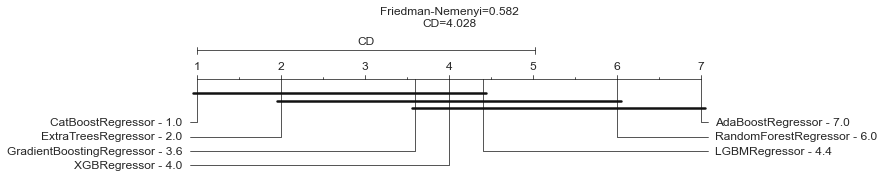

In [74]:
plot_comparisons(fried_result, names, cd, cd1, average_ranks)

In [92]:
resultsDF.to_csv("Results/static_regressors_full_results.csv", index=False)

In [91]:
resultsDF

,name,rmse,mae,r2
0,RandomForestRegressor,13.498161,8.925859,0.747856
1,ExtraTreesRegressor,13.142275,8.872368,0.760977
2,XGBRegressor,13.315518,8.998999,0.754634
3,LGBMRegressor,13.277657,9.004161,0.756027
4,GradientBoostingRegressor,13.206004,8.951496,0.758653
...,...,...,...,...
2,XGBRegressor,13.000033,8.840629,0.766123
3,LGBMRegressor,12.966076,8.877977,0.767343
4,GradientBoostingRegressor,12.943363,8.846868,0.768157
5,CatBoostRegressor,12.506272,8.483728,0.783551
